In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pgeocode
import xgboost as xgb
import shap
import lightgbm as lgb
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from catboost import CatBoostRegressor

In [3]:
sold = pd.read_csv("C:/Users/44756/Documents/Postgrad/DSA8030/Data/sold_treated.csv", dtype = {'brokered_by':'string', 'street':'string', 'zip_code':'string'}, parse_dates = ['prev_sold_date'])

In [4]:
# Add lat/long columns based on zip code
nomi = pgeocode.Nominatim('us')
location_data = nomi.query_postal_code(sold['zip_code'].tolist())
sold['latzip'] = location_data['latitude'].values
sold['longzip'] = location_data['longitude'].values

In [5]:
len(sold)

805120

In [6]:
# One hot encode state column
sold_dummy = pd.get_dummies(sold['state']).astype('int')
# enc = OneHotEncoder(sparse_output=False).astype('int')
# col = sold[['state']]
# enc_col = enc.fit_transform(col)
# state_df = pd.DataFrame(enc_col)
sold = pd.concat([sold, sold_dummy], axis = 1)

In [7]:
# Encode state column as numbers for CatBoostRegressor
states = sold.state.unique().tolist()
numbers = np.arange(0, len(states)+1)
state_n = pd.DataFrame([numbers, states]).T
state_n = state_n.rename(columns={0:'n', 1:'statename'})
sold = pd.merge(sold, state_n, how = 'left', left_on = 'state', right_on = 'statename')
sold

brokered_by     price     street       city          state zip_code  \
0           8147.0  150000.0  1963892.0  Blandford  Massachusetts    01008   
1          53016.0  285000.0    12355.0  Blandford  Massachusetts    01008   
2          53016.0  235000.0  1637754.0  Blandford  Massachusetts    01008   
3          71852.0   95000.0  1885253.0  Blandford  Massachusetts    01008   
4         107912.0  539000.0   152107.0  Blandford  Massachusetts    01008   
...            ...       ...        ...        ...            ...      ...   
805115     23009.0  359900.0   353094.0   Richland     Washington    99354   
805116     18208.0  350000.0  1062149.0   Richland     Washington    99354   
805117     76856.0  440000.0   405677.0   Richland     Washington    99354   
805118     53618.0  179900.0   761379.0   Richland     Washington    99354   
805119    108243.0  580000.0   307704.0   Richland     Washington    99354   

       prev_sold_date            county  po_box  bed  ...  Texas  Utah  \
0          2021-12-14  Berkshire County       0  3.0  ...      0     0   
1          2021-12-03  Berkshire County       0  3.0  ...      0     0   
2          2021-12-02  Berkshire County       0  3.0  ...      0     0   
3          2021-11-04  Berkshire County       0  3.0  ...      0     0   
4          2021-10-29  Berkshire County       0  3.0  ...      0     0   
...               ...               ...     ...  ...  ...    ...   ...   
805115     2022-03-25     Benton County       0  4.0  ...      0     0   
805116     2022-03-25     Benton County       0  3.0  ...      0     0   
805117     2022-03-24     Benton County       0  6.0  ...      0     0   
805118     2022-03-24     Benton County       0  2.0  ...      0     0   
805119     2022-03-23     Benton County       0  5.0  ...      0     0   

        Vermont  Virginia  Washington  West Virginia  Wisconsin  Wyoming   n  \
0             0         0           0              0          0        0   0   
1             0         0           0              0          0        0   0   
2             0         0           0              0          0        0   0   
3             0         0           0              0          0        0   0   
4             0         0           0              0          0        0   0   
...         ...       ...         ...            ...        ...      ...  ..   
805115        0         0           1              0          0        0  43   
805116        0         0           1              0          0        0  43   
805117        0         0           1              0          0        0  43   
805118        0         0           1              0          0        0  43   
805119        0         0           1              0          0        0  43   

            statename  
0       Massachusetts  
1       Massachusetts  
2       Massachusetts  
3       Massachusetts  
4       Massachusetts  
...               ...  
805115     Washington  
805116     Washington  
805117     Washington  
805118     Washington  
805119     Washington  

[805120 rows x 85 columns]

In [8]:
# Frequency encode city, street and broker
sold['cityfreq'] = sold['city'].map(sold['city'].value_counts())
sold['streetfreq'] = sold['street'].map(sold['street'].value_counts())
sold['brokerfreq'] = sold['brokered_by'].map(sold['brokered_by'].value_counts())

In [9]:
# Log transform target variable
sold['logprice'] = np.log(sold.price)

In [10]:
# Other column for feature selections for different models
sold['otherstate_lgbm'] = sold['state'].isin(['Indiana', 'Louisiana', 'Maine', 'Michigan', 'Minnesota', 'New Hampshire', 'North Dakota', 'South Dakota', 'Vermont', 'Wyoming']).astype('int')
sold['otherstate_xgb'] = sold['state'].isin(['Vermont', 'Indiana', 'North Dakota', 'New Mexico', 'New Hampshire', 'Minnesota', 'Maine', 'Delaware', 'Alabama', 'Wyoming']).astype('int')

In [11]:
# Split train/val and test before modelling
sold_train, sold_test = train_test_split(sold, test_size = 0.2, random_state=1)

In [12]:
def build_model(model_type, cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'], rand_state=1):
    X = sold_train[cols]
    y = sold_train['price']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=rand_state)

    model = model_type
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    resids = y_val - y_val_pred
    percenterror = (y_val - y_val_pred) / y_val
    print('R^2', model.score(X_val, y_val))
    print('RMSE', root_mean_squared_error(y_val, y_val_pred))
    print('MAE', mean_absolute_error(y_val, y_val_pred))
    print('Positive residuals:', len(resids[resids > 0]))
    print('Negative residuals:', len(resids[resids < 0]))
    print('Average positive residual:', np.mean(resids[resids > 0]))
    print('Average negative residual:', np.mean(resids[resids < 0]))
    print('Average percentage error:', np.mean(abs(percenterror)))
    plt.scatter(y_val, y_val_pred, s = 0.01)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    return model, X, y_val_pred, resids, percenterror

In [13]:
def build_model_log(model_type, cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'], rand_state=1):
    X = sold_train[cols]
    y = sold_train['logprice']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=rand_state)

    model = model_type
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    y_val_pred_exp = np.exp(y_val_pred)
    y_val_exp = np.exp(y_val)
    resids = y_val_exp - y_val_pred_exp
    percenterror = (y_val_exp - y_val_pred_exp) / y_val_exp
    print('R^2', model.score(X_val, y_val))
    print('RMSE', root_mean_squared_error(y_val_exp, y_val_pred_exp))
    print('MAE', mean_absolute_error(y_val_exp, y_val_pred_exp))
    print('Positive residuals:', len(resids[resids > 0]))
    print('Negative residuals:', len(resids[resids < 0]))
    print('Average positive residual:', np.mean(resids[resids > 0]))
    print('Average negative residual:', np.mean(resids[resids < 0]))
    print('Average percentage error:', np.mean(abs(percenterror)))
    plt.scatter(y_val_exp, y_val_pred_exp, s = 0.01)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    return model, X, y_val_pred_exp, resids, percenterror

Linear Regression (main dataset variables only)

R^2 0.4594368454723302
RMSE 363049.3468927382
MAE 212114.25748569053
Positive residuals: 71480
Negative residuals: 89544
Average positive residual: 238290.45205349792
Average negative residual: -191218.67109568263
Average percentage error: 21.951571882114603


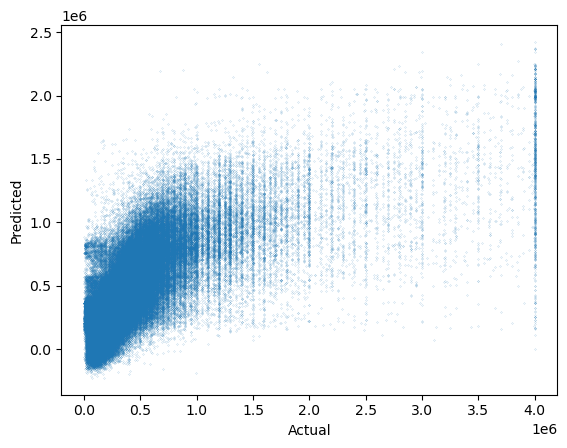

In [25]:
model_lr1, X_lr1, y_val_pred_lr1, resids_lr1, percenterror_lr1 = build_model(LinearRegression(), ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

In [11]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pd.DataFrame({'feature':model_lr1.feature_names_in_, 'coeff':model_lr1.coef_, 'abs_coeff':abs(model_lr1.coef_)}).sort_values('abs_coeff', ascending = False))
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

feature          coeff      abs_coeff
52                  Utah  688827.955861  688827.955861
16  District of Columbia  501624.858395  501624.858395
29         Massachusetts  473801.522492  473801.522492
40              New York  366246.150791  366246.150791
51                 Texas -351644.071873  351644.071873
26             Louisiana -326902.200670  326902.200670
39            New Mexico -316102.678168  316102.678168
37         New Hampshire  302871.883854  302871.883854
32           Mississippi -296670.936006  296670.936006
47          Rhode Island  286094.019161  286094.019161
10               Arizona -284379.647608  284379.647608
44              Oklahoma -266648.208031  266648.208031
58               Wyoming -265153.072153  265153.072153
24                Kansas -233409.755104  233409.755104
38            New Jersey  232907.714756  232907.714756
53               Vermont  226131.977264  226131.977264
9                Alabama -221572.196656  221572.196656
11              Arkansas -206237.915152  206237.915152
14           Connecticut  195951.236878  195951.236878
18               Georgia -170057.025401  170057.025401
12            California  152475.827139  152475.827139
33              Missouri -152299.083107  152299.083107
17               Florida -143803.673805  143803.673805
1                   bath  123914.396312  123914.396312
27                 Maine  122338.148736  122338.148736
55            Washington  119425.824128  119425.824128
50             Tennessee -112571.487576  112571.487576
48        South Carolina -101493.320509  101493.320509
25              Kentucky  -91432.532823   91432.532823
34               Montana   83735.705488   83735.705488
41        North Carolina  -73206.977373   73206.977373
28              Maryland   71471.862798   71471.862798
54              Virginia   69340.811081   69340.811081
36                Nevada  -66699.511658   66699.511658
56         West Virginia  -63910.440861   63910.440861
22               Indiana  -61416.094417   61416.094417
13              Colorado  -58753.086338   58753.086338
30              Michigan   58340.504359   58340.504359
15              Delaware   53571.567325   53571.567325
42          North Dakota  -50390.805450   50390.805450
35              Nebraska  -50352.833612   50352.833612
57             Wisconsin   48012.469220   48012.469220
20                 Idaho  -47068.034616   47068.034616
23                  Iowa  -41130.083836   41130.083836
7             streetfreq  -41037.558623   41037.558623
0                    bed  -40363.889700   40363.889700
46          Pennsylvania   38443.412476   38443.412476
43                  Ohio  -33313.486650   33313.486650
19                Hawaii   28581.618938   28581.618938
4                 latzip  -21626.463377   21626.463377
45                Oregon  -13676.638974   13676.638974
49          South Dakota  -12258.481680   12258.481680
5                longzip   -9182.217757    9182.217757
2               acre_lot    6663.444145    6663.444145
21              Illinois   -4929.190591    4929.190591
31             Minnesota   -2711.600400    2711.600400
3             house_size     208.948651     208.948651
6               cityfreq      14.010114      14.010114
8             brokerfreq       9.343444       9.343444

Linear Regression Model (baseline + climate variables)

R^2 0.4944943487438648
RMSE 351079.48063936684
MAE 205990.10762577198
Positive residuals: 71924
Negative residuals: 89100
Average positive residual: 230338.4166504883
Average negative residual: -186335.4748727563
Average percentage error: 21.643657902974162


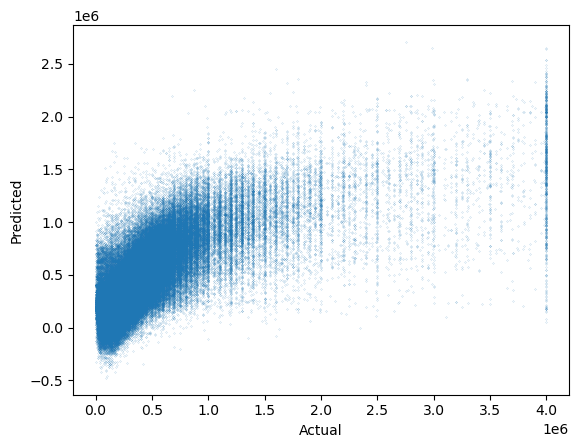

In [12]:
model_lr2, X_lr2, y_val_pred_lr2, resids_lr2, percenterror_lr2 = build_model(LinearRegression(), ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

In [13]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pd.DataFrame({'feature':model_lr2.feature_names_in_, 'coeff':model_lr2.coef_, 'abs_coeff':abs(model_lr2.coef_)}).sort_values('abs_coeff', ascending = False))
pd.reset_option('display.max_columns')

feature          coeff      abs_coeff
23                Hawaii -794961.300366  794961.300366
56                  Utah  553614.797995  553614.797995
20  District of Columbia  521516.707292  521516.707292
33         Massachusetts  477130.087384  477130.087384
30             Louisiana -353976.171579  353976.171579
55                 Texas -347990.024334  347990.024334
62               Wyoming -332980.015592  332980.015592
41         New Hampshire  321137.446183  321137.446183
44              New York  262832.612529  262832.612529
57               Vermont  258902.750562  258902.750562
16            California  249008.279939  249008.279939
51          Rhode Island  248496.587808  248496.587808
49                Oregon -247445.708763  247445.708763
36           Mississippi -246813.575882  246813.575882
42            New Jersey  239650.336434  239650.336434
18           Connecticut  221715.262477  221715.262477
15              Arkansas -195420.965010  195420.965010
37              Missouri -170748.521341  170748.521341
48              Oklahoma -161918.995490  161918.995490
13               Alabama -149805.380698  149805.380698
31                 Maine  142066.716477  142066.716477
58              Virginia  138178.460124  138178.460124
21               Florida -136647.417603  136647.417603
47                  Ohio -136222.986641  136222.986641
14               Arizona  123605.047609  123605.047609
28                Kansas -116084.222127  116084.222127
1                   bath  114871.368581  114871.368581
59            Washington -105798.030205  105798.030205
27                  Iowa -103071.051916  103071.051916
54             Tennessee  -98140.095846   98140.095846
25              Illinois  -97933.360519   97933.360519
29              Kentucky  -89131.670604   89131.670604
32              Maryland   88350.857044   88350.857044
22               Georgia  -86133.060568   86133.060568
24                 Idaho   82929.160203   82929.160203
26               Indiana  -76354.498175   76354.498175
39              Nebraska   62478.230489   62478.230489
10               maxtemp  -56246.537155   56246.537155
46          North Dakota  -51483.685072   51483.685072
11               mintemp   51166.880031   51166.880031
40                Nevada   48189.811107   48189.811107
19              Delaware   45852.360381   45852.360381
7             streetfreq  -38576.319887   38576.319887
4                 latzip  -38045.580758   38045.580758
35             Minnesota  -32447.272857   32447.272857
52        South Carolina  -30736.038795   30736.038795
0                    bed  -29706.949534   29706.949534
50          Pennsylvania   27947.488745   27947.488745
61             Wisconsin  -25019.859330   25019.859330
53          South Dakota   19165.798470   19165.798470
17              Colorado   18771.305989   18771.305989
60         West Virginia   16982.391587   16982.391587
5                longzip  -14122.967252   14122.967252
2               acre_lot   11580.104218   11580.104218
34              Michigan   10134.455929   10134.455929
45        North Carolina    9241.170280    9241.170280
12               avgtemp   -8623.648561    8623.648561
38               Montana   -8147.331565    8147.331565
43            New Mexico    7513.117931    7513.117931
9          precipitation     233.029025     233.029025
3             house_size     207.800642     207.800642
6               cityfreq      13.391024      13.391024
8             brokerfreq       7.388281       7.388281

Linear Regression Model (baseline + facilities/demographic variables)

R^2 0.6019764479739904
RMSE 311527.8122556024
MAE 184611.40803146255
Positive residuals: 76237
Negative residuals: 84787
Average positive residual: 194735.97545589565
Average negative residual: -175507.8114100878
Average percentage error: 22.79431728747073


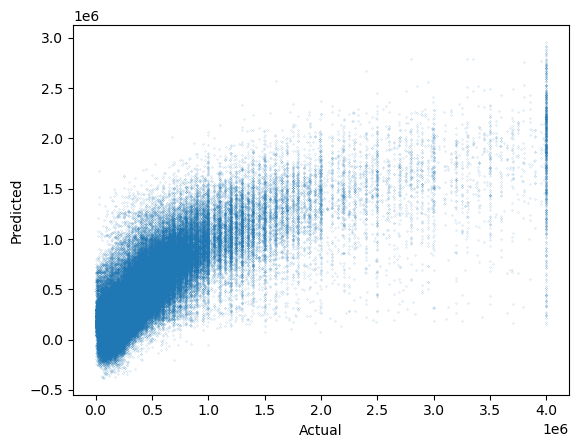

In [14]:
model_lr3, X_lr3, y_val_pred_lr3, resids_lr3, percenterror_lr3 = build_model(LinearRegression(),['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pd.DataFrame({'feature':model_lr3.feature_names_in_, 'coeff':model_lr3.coef_, 'abs_coeff':abs(model_lr3.coef_)}).sort_values('abs_coeff', ascending = False))
pd.reset_option('display.max_columns')

feature          coeff      abs_coeff
63                  Utah  460923.003443  460923.003443
40         Massachusetts  427254.604411  427254.604411
48         New Hampshire  340025.209984  340025.209984
62                 Texas -318670.536857  318670.536857
64               Vermont  301096.988501  301096.988501
21               Arizona -276653.471085  276653.471085
51              New York  274220.720977  274220.720977
58          Rhode Island  273964.399499  273964.399499
69               Wyoming -261673.709049  261673.709049
25           Connecticut  253527.975983  253527.975983
37             Louisiana -242829.793867  242829.793867
30                Hawaii -233516.026094  233516.026094
27  District of Columbia  216754.741276  216754.741276
56                Oregon -213379.373599  213379.373599
47                Nevada -212792.780064  212792.780064
43           Mississippi -207014.920062  207014.920062
55              Oklahoma -194828.734905  194828.734905
50            New Mexico -181719.060966  181719.060966
49            New Jersey  181570.806318  181570.806318
38                 Maine  167039.080374  167039.080374
35                Kansas -151336.315489  151336.315489
22              Arkansas -145340.757995  145340.757995
26              Delaware  132927.299511  132927.299511
20               Alabama -122212.454940  122212.454940
44              Missouri -120009.616156  120009.616156
9                 po_box  114801.072518  114801.072518
66            Washington -111563.441348  111563.441348
41              Michigan  104797.896981  104797.896981
28               Florida -101574.171651  101574.171651
32              Illinois  -95862.600186   95862.600186
29               Georgia  -94593.242266   94593.242266
23            California  -94268.507851   94268.507851
1                   bath   85311.972379   85311.972379
39              Maryland   83007.199127   83007.199127
65              Virginia   77536.442438   77536.442438
45               Montana   71322.577524   71322.577524
57          Pennsylvania   71203.192829   71203.192829
24              Colorado  -71024.803722   71024.803722
52        North Carolina   51908.629667   51908.629667
42             Minnesota  -46909.130105   46909.130105
53          North Dakota  -42882.972366   42882.972366
61             Tennessee   42411.040958   42411.040958
68             Wisconsin   38987.772206   38987.772206
31                 Idaho  -36683.452268   36683.452268
33               Indiana  -35111.464422   35111.464422
67         West Virginia   30411.192169   30411.192169
46              Nebraska  -30005.085095   30005.085095
60          South Dakota   28625.292011   28625.292011
7             streetfreq  -27539.943438   27539.943438
2               acre_lot   21374.794194   21374.794194
4                 latzip  -20122.212514   20122.212514
0                    bed   19524.027543   19524.027543
5                longzip  -13657.079463   13657.079463
34                  Iowa   10808.197451   10808.197451
59        South Carolina    4951.095393    4951.095393
54                  Ohio   -4566.426971    4566.426971
36              Kentucky    1747.489536    1747.489536
14             dmairport    -356.150923     356.150923
13             dlairport    -330.274899     330.274899
12              dhighway     209.967011     209.967011
3             house_size     167.004068     167.004068
15                dshore     -88.667330      88.667330
11               density      69.466650      69.466650
16            nobusiness      46.389204      46.389204
6               cityfreq      -6.425505       6.425505
19           tax_returns      -6.041793       6.041793
10            population      -5.763278       5.763278
8             brokerfreq       3.202539       3.202539
17           totalincome       1.578547       1.578547
18        adjustedincome      -1.415185       1.415185

Linear Regression Model (all variables)

R^2 0.6066273720311042
RMSE 309702.355327632
MAE 182449.0914626042
Positive residuals: 76482
Negative residuals: 84542
Average positive residual: 192039.44173370473
Average negative residual: -173773.05860988822
Average percentage error: 22.18745574418501


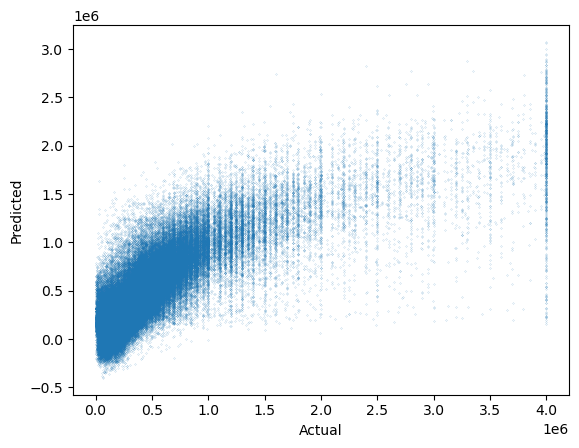

In [ ]:
model_lr4, X_lr4, y_val_pred_lr4, resids_lr4, percenterror_lr4 = build_model(LinearRegression())

In [17]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pd.DataFrame({'feature':model_lr4.feature_names_in_, 'coeff':model_lr4.coef_, 'abs_coeff':abs(model_lr4.coef_)}).sort_values('abs_coeff', ascending = False))
pd.reset_option('display.max_columns')

feature          coeff      abs_coeff
44         Massachusetts  403850.902043  403850.902043
34                Hawaii -356880.864981  356880.864981
73               Wyoming -346117.384874  346117.384874
67                  Utah  342029.172136  342029.172136
52         New Hampshire  301386.228456  301386.228456
66                 Texas -293625.231608  293625.231608
31  District of Columbia  256926.634107  256926.634107
62          Rhode Island  239857.383766  239857.383766
68               Vermont  232021.038293  232021.038293
29           Connecticut  231672.938433  231672.938433
55              New York  219386.995304  219386.995304
41             Louisiana -219234.683602  219234.683602
53            New Jersey  180736.008134  180736.008134
59              Oklahoma -180544.268541  180544.268541
47           Mississippi -175572.544087  175572.544087
26              Arkansas -171488.534611  171488.534611
39                Kansas -142673.236673  142673.236673
48              Missouri -140240.652290  140240.652290
54            New Mexico -131276.117818  131276.117818
42                 Maine  130237.096150  130237.096150
30              Delaware  129228.245445  129228.245445
60                Oregon -123688.926059  123688.926059
51                Nevada -118601.593528  118601.593528
28              Colorado -116128.518544  116128.518544
36              Illinois -110221.456025  110221.456025
69              Virginia  109770.323487  109770.323487
13                po_box  103075.194150  103075.194150
24               Alabama  -97070.774218   97070.774218
43              Maryland   94680.647985   94680.647985
57          North Dakota  -86842.029421   86842.029421
1                   bath   84320.186365   84320.186365
45              Michigan   83583.863050   83583.863050
32               Florida  -79485.986262   79485.986262
25               Arizona  -75704.197615   75704.197615
33               Georgia  -75660.521580   75660.521580
27            California   66102.972133   66102.972133
56        North Carolina   64882.205129   64882.205129
46             Minnesota  -59353.983914   59353.983914
35                 Idaho   57180.659265   57180.659265
37               Indiana  -49877.111757   49877.111757
58                  Ohio  -47994.539906   47994.539906
61          Pennsylvania   44826.232899   44826.232899
38                  Iowa  -41496.361305   41496.361305
4                 latzip  -36157.383523   36157.383523
40              Kentucky  -31528.800061   31528.800061
71         West Virginia   30329.691482   30329.691482
7             streetfreq  -27974.944673   27974.944673
49               Montana   25149.292449   25149.292449
63        South Carolina   24667.493634   24667.493634
11               mintemp   24369.195915   24369.195915
50              Nebraska  -23661.196375   23661.196375
72             Wisconsin   20968.187960   20968.187960
2               acre_lot   20755.768177   20755.768177
0                    bed   19734.356326   19734.356326
12               avgtemp  -18012.621507   18012.621507
10               maxtemp  -17892.487969   17892.487969
5                longzip  -12015.369474   12015.369474
65             Tennessee    7092.478301    7092.478301
70            Washington   -7082.498114    7082.498114
64          South Dakota    5485.330041    5485.330041
9          precipitation    -820.547699     820.547699
18             dmairport    -568.593963     568.593963
17             dlairport    -323.012801     323.012801
16              dhighway     268.239044     268.239044
3             house_size     168.336210     168.336210
15               density      62.092249      62.092249
20            nobusiness      40.980749      40.980749
19                dshore      35.726613      35.726613
23           tax_returns      -6.361242       6.361242
14            population      -5.160499       5.160499
6               cityfreq      -3.399796       3.399796
8             brokerfreq       2.887109       2.887109
21

XGBoost (all variables, all vars Vermont, Indiana, North Dakota, New Mexico, New Hampshire, Minnesota, Maine, Delaware, Alabama, Wyoming)

R^2 0.8291569183389692
RMSE 204099.12271183284
MAE 104614.58455939015
Positive residuals: 74547
Negative residuals: 86477
Average positive residual: 113273.04198685489
Average negative residual: -97150.61118097491
Average percentage error: 24.886877533340595


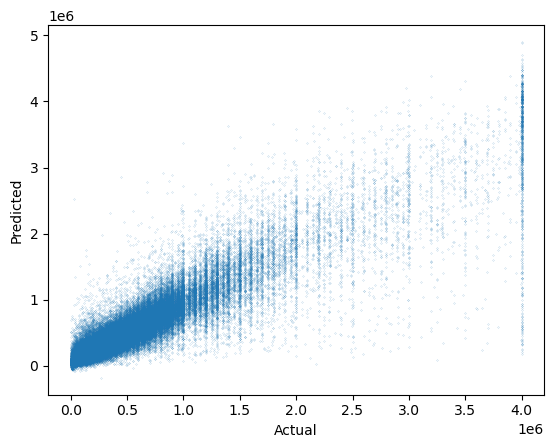

In [ ]:
model_xgb1, X_xgb1, y_val_pred_xgb1, resids_xgb1, percenterror_xgb1 = build_model(xgb.XGBRegressor(eval_metric=['mae', 'rmse']), cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns','Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maryland', 'Massachusetts', 'Michigan', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Jersey', 'New York', 'North Carolina', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin'])

In [19]:
params = [{'max_depth': [3,4,5,6,7,8,9],
         'learning_rate': [0.2,0.3,0.4],
         'min_child_weight': [0,1,2,3]}]

gs_xgb = GridSearchCV(xgb.XGBRegressor(eval_metric=['mae', 'rmse']),
                      param_grid=params,
                      scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'],
                      refit='r2',
                      cv=5)

X = sold_train[['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']]
y = sold_train['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

gs_xgb.fit(X_train, y_train)
gs_xgb.best_params_

{'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 3}

Best hyperparameters of the above three seem to be 0.2, 10/11 (different metrics prefer either), 3

R^2 0.848040264752033
RMSE 192489.3490270022
MAE 94155.15747042252
Positive residuals: 74809
Negative residuals: 86215
Average positive residual: 101782.88143014797
Average negative residual: -87536.55975885142
Average percentage error: 28.047233233229008


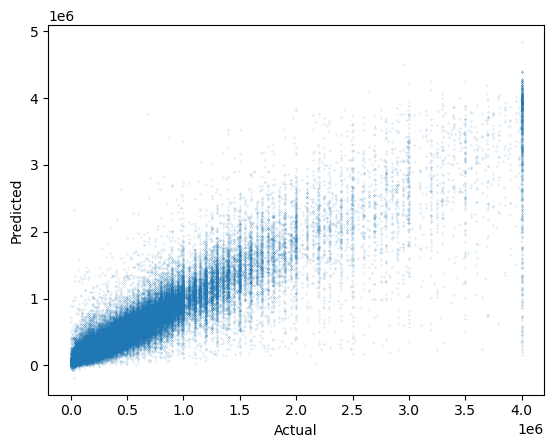

In [23]:
model_xgb2, X_xgb2, y_val_pred_xgb2, resids_xgb2, percenterror_xgb2 = build_model(xgb.XGBRegressor(eval_metric=['mae', 'rmse'], learning_rate = 0.2, max_depth = 10, min_child_weight = 3), cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns','Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maryland', 'Massachusetts', 'Michigan', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Jersey', 'New York', 'North Carolina', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin','otherstate_xgb'])

R^2 0.8483896616286333
RMSE 192267.9289211224
MAE 93085.3235226665
Positive residuals: 74946
Negative residuals: 86078
Average positive residual: 100037.75088607786
Average negative residual: -87032.01581130904
Average percentage error: 29.880506686747346


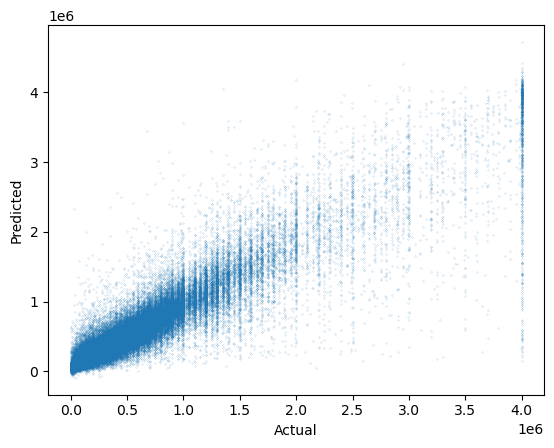

In [19]:
model_xgb4, X_xgb4, y_val_pred_xgb4, resids_xgb4, percenterror_xgb4 = build_model(xgb.XGBRegressor(eval_metric=['mae', 'rmse'], learning_rate = 0.2, max_depth = 11, min_child_weight = 3), cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns','Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maryland', 'Massachusetts', 'Michigan', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Jersey', 'New York', 'North Carolina', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'otherstate_xgb'])

In [20]:
joblib.dump(model_xgb4, "C:/Users/44756/Documents/Postgrad/DSA8030/model_xgb.joblib")

['C:/Users/44756/Documents/Postgrad/DSA8030/model_xgb.joblib']

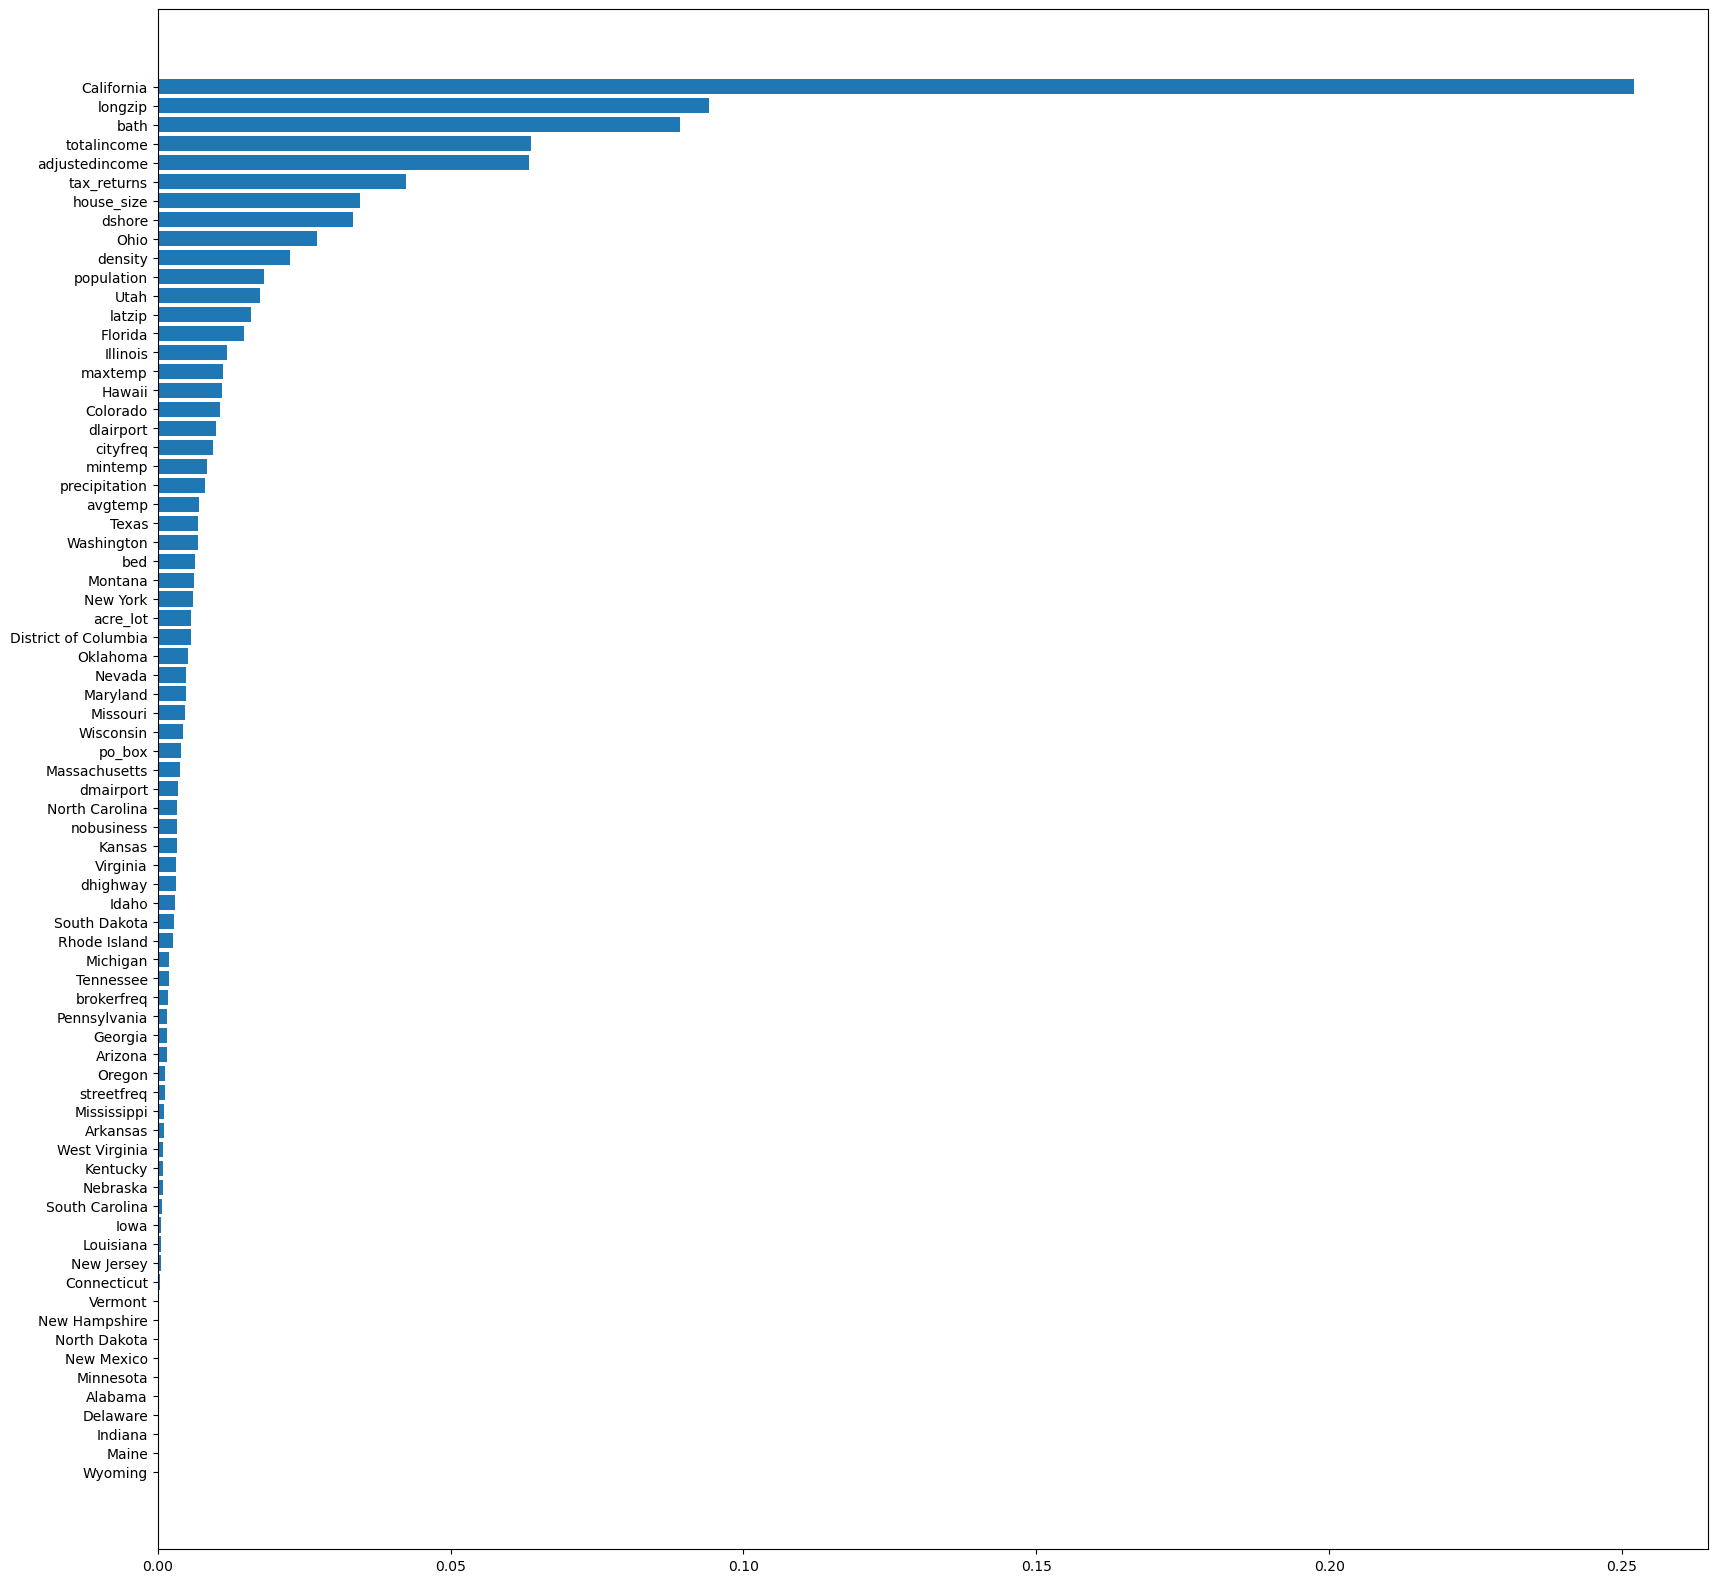

In [19]:
sorted_idx = model_xgb1.feature_importances_.argsort()
plt.figure(figsize=(20,20))
plt.barh(X_xgb1.columns[sorted_idx], model_xgb1.feature_importances_[sorted_idx])
plt.show()

R^2 0.8215889397001391
RMSE 208570.7134846035
MAE 103018.95304028521
Positive residuals: 72816
Negative residuals: 88208
Average positive residual: 114345.0601718595
Average negative residual: -93669.21359609974
Average percentage error: 20.274230619617395


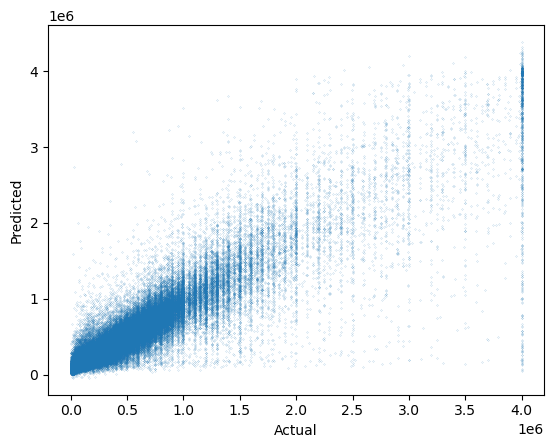

In [14]:
# Feature selection, importance > 1%
model_xgb3, X_xgb3, y_val_pred_xgb3, resids_xgb3, percenterror_xgb3 = build_model(xgb.XGBRegressor(eval_metric=['mae', 'rmse'], learning_rate = 0.2, max_depth = 10, min_child_weight = 3), cols = ['California', 'longzip', 'bath', 'totalincome', 'adjustedincome', 'tax_returns', 'house_size', 'dshore', 'Ohio', 'density', 'population', 'Utah', 'latzip', 'Florida', 'Illinois', 'maxtemp', 'Hawaii', 'Colorado'])

In [66]:
pd.DataFrame([X_xgb1.columns, model_xgb1.feature_importances_]).T.sort_values(by = 1, ascending = False)

0         1
27            California  0.252024
5                longzip  0.094091
1                   bath  0.089192
21           totalincome   0.06377
22        adjustedincome  0.063312
23           tax_returns   0.04243
3             house_size  0.034463
19                dshore   0.03334
58                  Ohio  0.027272
15               density  0.022612
14            population  0.018173
67                  Utah  0.017403
4                 latzip  0.015893
32               Florida  0.014726
36              Illinois  0.011795
10               maxtemp  0.011205
34                Hawaii  0.010899
28              Colorado  0.010569
17             dlairport  0.009973
6               cityfreq  0.009371
11               mintemp  0.008472
9          precipitation  0.008113
12               avgtemp  0.007091
66                 Texas  0.006892
70            Washington  0.006792
0                    bed  0.006414
49               Montana  0.006133
55              New York  0.005946
2               acre_lot  0.005701
31  District of Columbia  0.005672
59              Oklahoma  0.005172
51                Nevada  0.004807
43              Maryland  0.004783
48              Missouri  0.004656
72             Wisconsin  0.004332
13                po_box  0.003922
44         Massachusetts   0.00385
18             dmairport  0.003437
56        North Carolina  0.003351
20            nobusiness  0.003313
39                Kansas  0.003286
69              Virginia  0.003189
16              dhighway  0.003159
35                 Idaho  0.003025
64          South Dakota  0.002718
62          Rhode Island   0.00253
45              Michigan  0.001987
65             Tennessee   0.00192
8             brokerfreq  0.001828
61          Pennsylvania   0.00159
33               Georgia  0.001546
25               Arizona   0.00151
60                Oregon  0.001299
7             streetfreq  0.001175
47           Mississippi  0.001116
26              Arkansas  0.001011
71         West Virginia  0.000981
40              Kentucky  0.000942
50              Nebraska  0.000923
63        South Carolina  0.000793
38                  Iowa  0.000631
41             Louisiana  0.000627
53            New Jersey  0.000486
29           Connecticut  0.000368
68               Vermont       0.0
37               Indiana       0.0
57          North Dakota       0.0
54            New Mexico       0.0
52         New Hampshire       0.0
46             Minnesota       0.0
42                 Maine       0.0
30              Delaware       0.0
24               Alabama       0.0
73               Wyoming       0.0

In [20]:
explainer_xgb1 = shap.Explainer(model_xgb1)
X_train, X_val, y_train, y_val = train_test_split(X_xgb1, sold_train['price'], test_size=0.25, random_state=1)
shap_values_xgb1 = explainer_xgb1.shap_values(X_val)

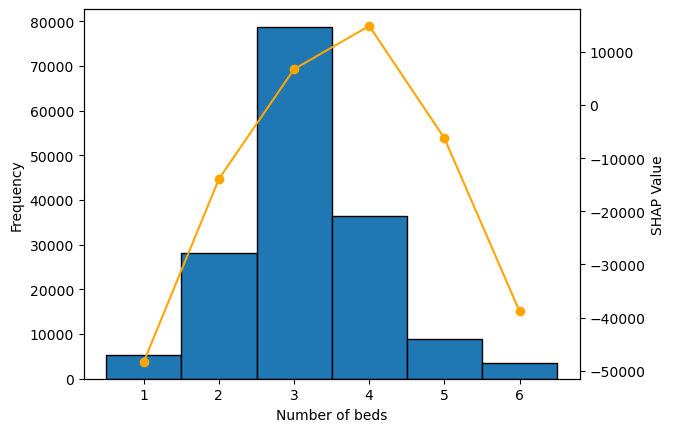

In [21]:
# Bed univariate
fig, ax = plt.subplots()

hist = ax.hist(X_val.bed, ec = 'black', bins = np.arange(0.5,7.5))
shaps = [np.median(shap_values_xgb1[X_val.bed == x, 0]) for x in np.arange(1,7)]
ax.set_xticks(ticks = np.arange(0,7), labels = np.arange(0,7))
ax.set_xlabel('Number of beds')
ax.set_ylabel('Frequency')
ax2 = ax.twinx()
ax2.plot(np.arange(1,7), shaps, color = 'orange')
ax2.scatter(np.arange(1,7), shaps, color = 'orange')
ax2.set_ylabel('SHAP Value')
plt.show()

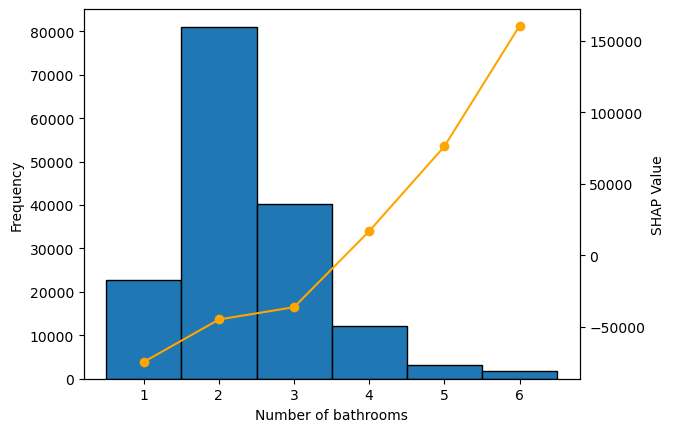

In [22]:
# Bath univariate
fig, ax = plt.subplots()

hist = ax.hist(X_val.bath, ec = 'black', bins = np.arange(0.5,7.5))
shaps = [np.median(shap_values_xgb1[X_val.bed == x, 1]) for x in np.arange(1,7)]
ax.set_xticks(ticks = np.arange(0,7), labels = np.arange(0,7))
ax.set_xlabel('Number of bathrooms')
ax.set_ylabel('Frequency')
ax2 = ax.twinx()
ax2.plot(np.arange(1,7), shaps, color = 'orange')
ax2.scatter(np.arange(1,7), shaps, color = 'orange')
ax2.set_ylabel('SHAP Value')
plt.show()

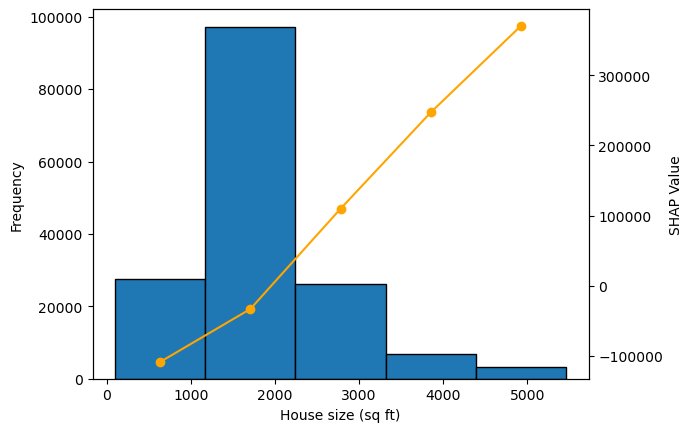

In [59]:
# House size univariate
fig, ax = plt.subplots()

hist = ax.hist(X_val.house_size, ec = 'black', bins = 5)
midpts = [((hist[1][x] + hist[1][x+1])/2) for x in range(len(hist[1])-1)]
shaps = [np.median(shap_values_xgb1[(X_val.house_size >= hist[1][x]) & (X_val.house_size < hist[1][x+1]), 3]) for x in range(len(hist[1])-1)]
ax.set_xlabel('House size (sq ft)')
ax.set_ylabel('Frequency')
ax2 = ax.twinx()
ax2.plot(midpts, shaps, color = 'orange')
ax2.scatter(midpts, shaps, color = 'orange')
ax2.set_ylabel('SHAP Value')
plt.show()

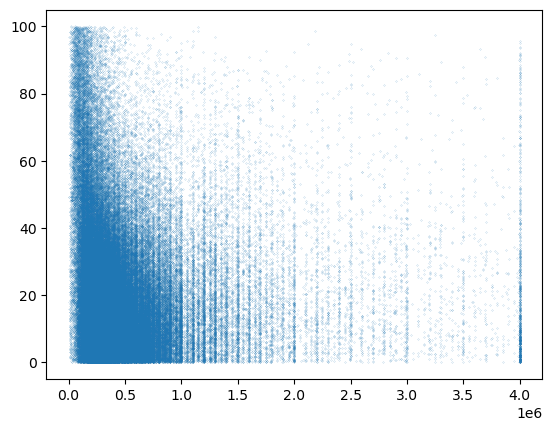

In [56]:
fig, ax = plt.subplots()

ax.scatter(y_val[abs(percenterror_xgb1) < 1], abs(percenterror_xgb1*100)[abs(percenterror_xgb1) < 1], s = 0.01)

Decision Tree Regressor (all variables, default parameters)

R^2 0.6861776352047394
RMSE 276620.51466429344
MAE 126901.2251043832
Positive residuals: 77760
Negative residuals: 79541
Average positive residual: 127661.24687743837
Average negative residual: -132097.96600518716
Average percentage error: 47.48606744989504


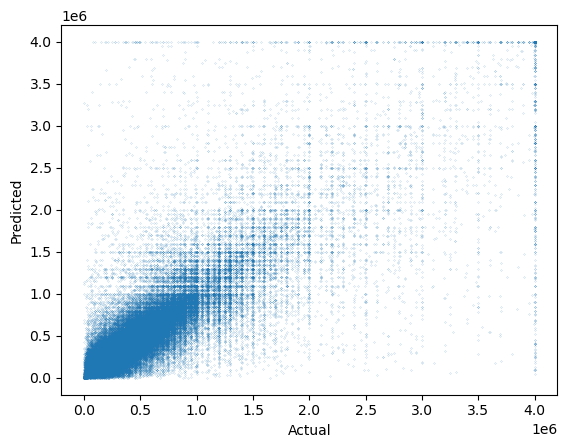

In [24]:
model_dt1, X_dt1, y_val_pred_dt1, resids_dt1, percenterror_dt1 = build_model(DecisionTreeRegressor())

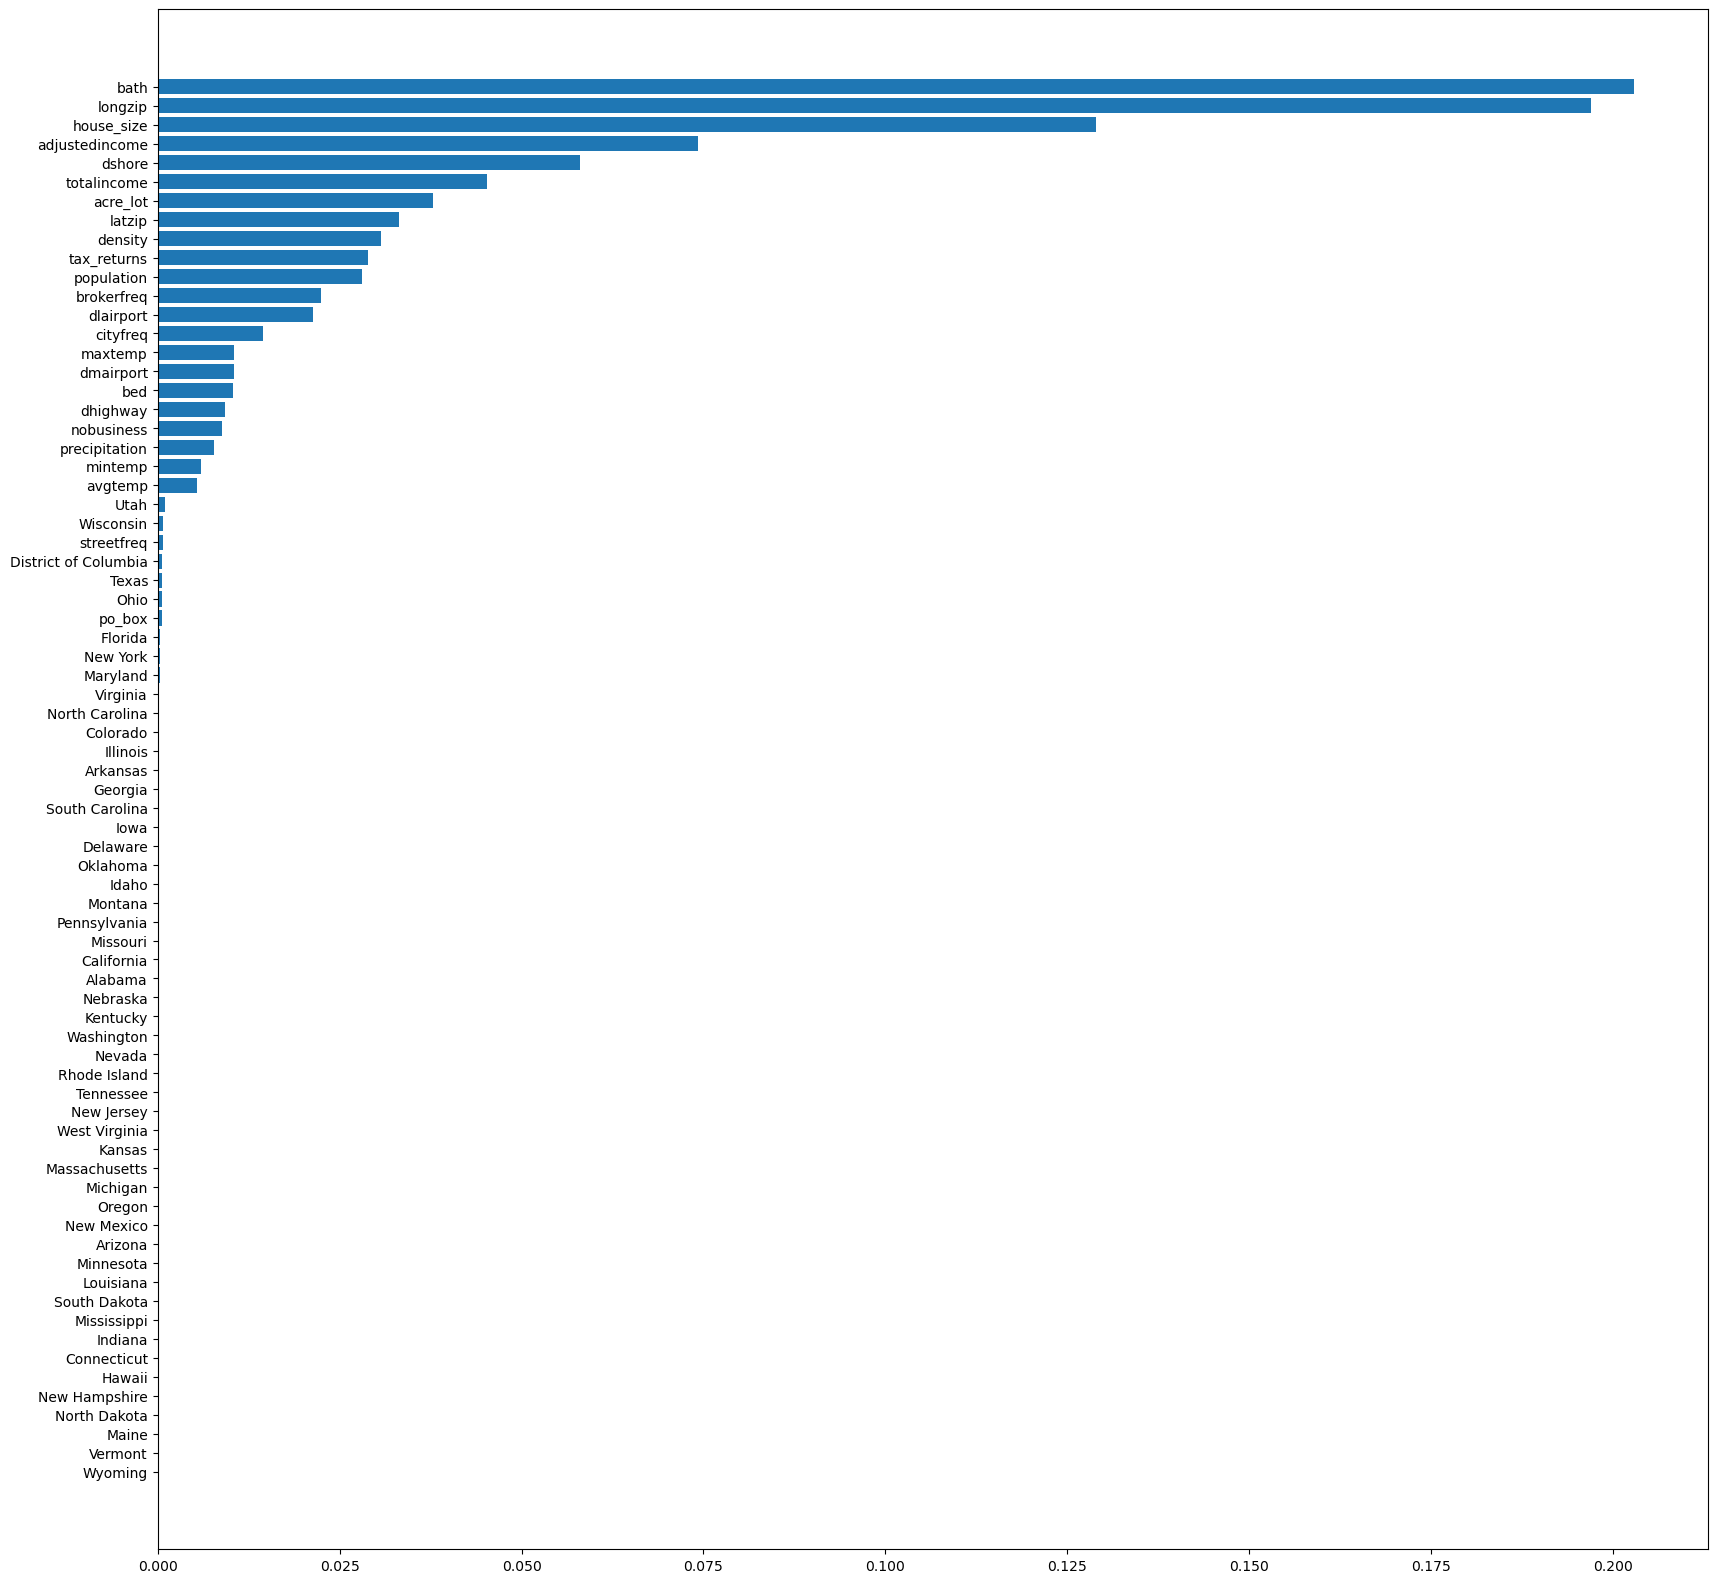

In [25]:
sorted_idx = model_dt1.tree_.compute_feature_importances().argsort()
plt.figure(figsize=(20,20))
plt.barh(X_dt1.columns[sorted_idx], model_dt1.feature_importances_[sorted_idx])
plt.show()

Random Forest Regressor (all variables, default hyperparameters)

R^2 0.836109960087424
RMSE 199902.7277001317
MAE 93345.71383973154
Positive residuals: 72579
Negative residuals: 88380
Average positive residual: 99998.55700629053
Average negative residual: -87950.94994760546
Average percentage error: 38.858794034955466


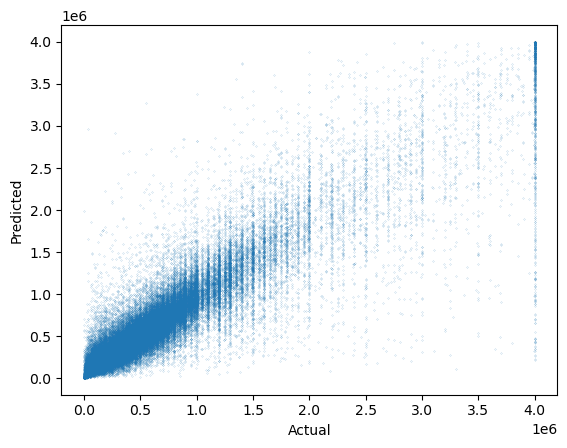

In [26]:
model_rf1, X_rf1, y_val_pred_rf1, resids_rf1, percenterror_rf1 = build_model(RandomForestRegressor())

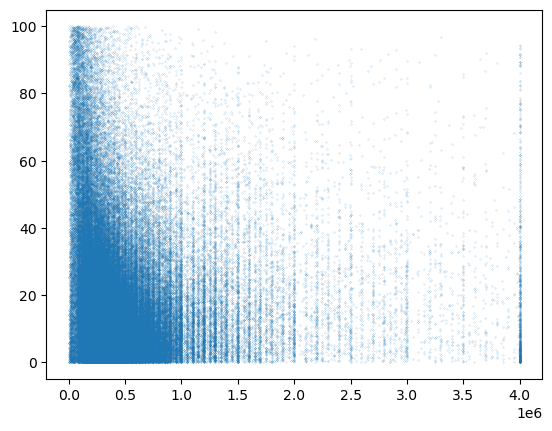

In [57]:
fig, ax = plt.subplots()

ax.scatter(y_val[abs(percenterror_rf1) < 1], abs(percenterror_rf1*100)[abs(percenterror_rf1) < 1], s = 0.01)

In [ ]:
explainer_rf1 = shap.Explainer(model_rf1)
X_train, X_val, y_train, y_val = train_test_split(X_rf1, sold_train['price'], test_size=0.25, random_state=1)
shap_values_rf1 = explainer_rf1.shap_values(X_val)

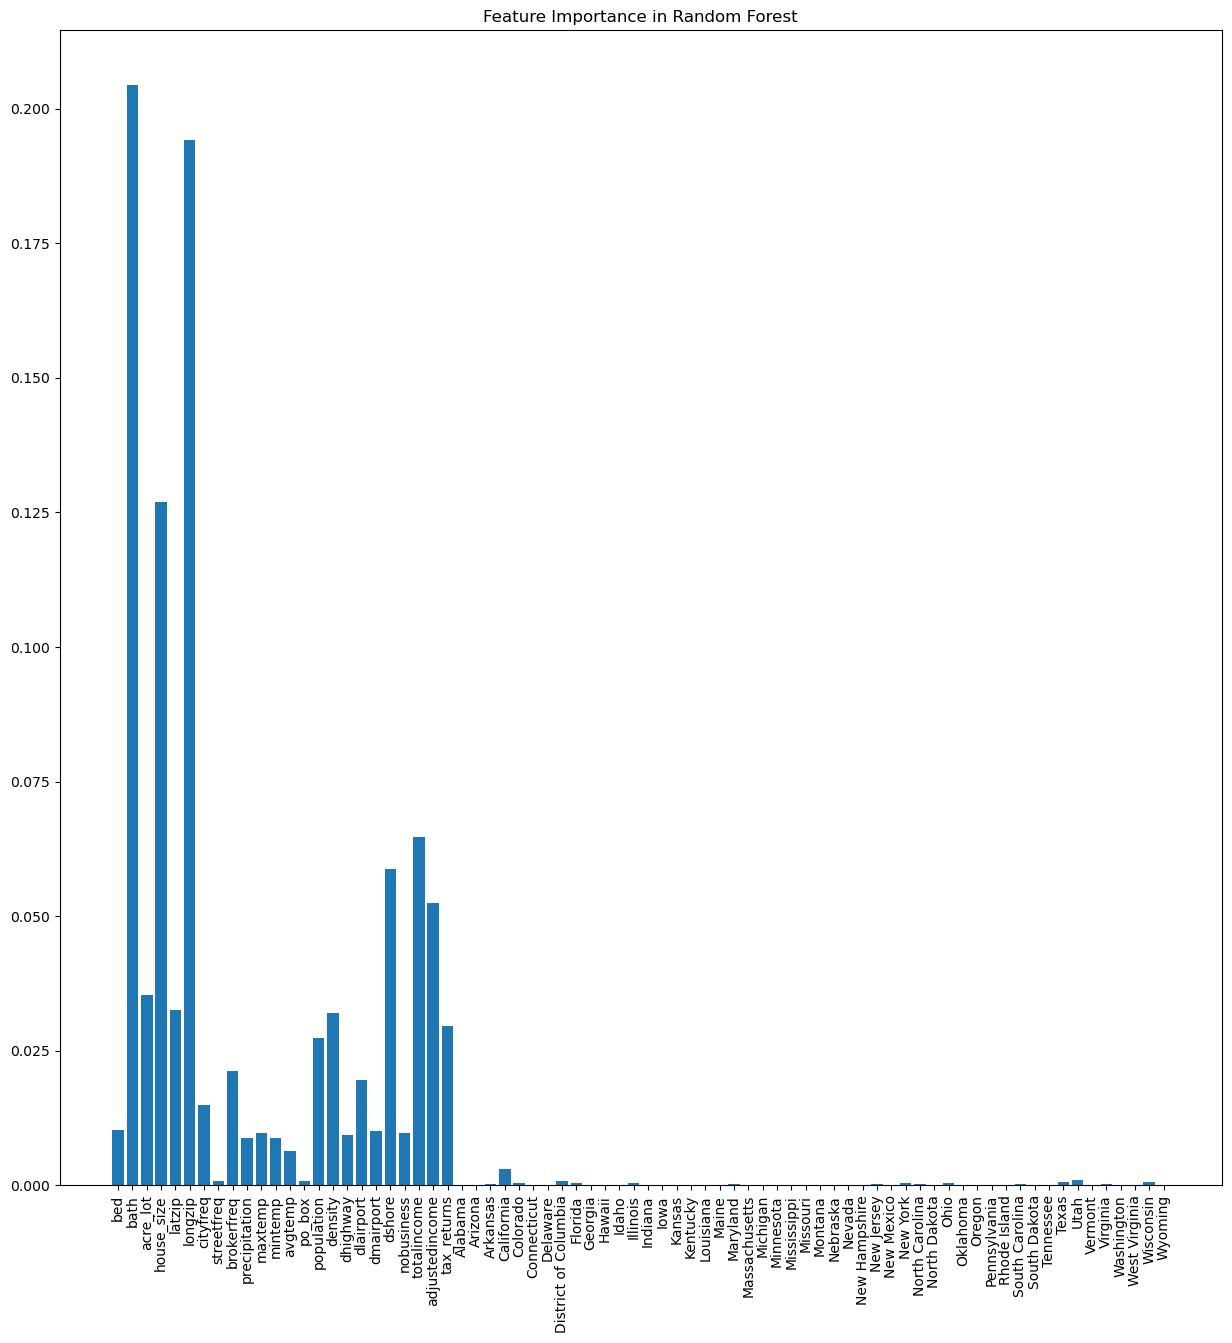

In [60]:
importance = model_rf1.feature_importances_
plt.subplots(figsize=(15,15))
plt.bar(range(X_rf1.shape[1]), importance)
plt.xticks(range(X_rf1.shape[1]), X_rf1.columns, rotation=90)
plt.title("Feature Importance in Random Forest")
plt.show()

In [ ]:
params = [{'criterion': ['squared_error'],
           'n_estimators': [50,100,150],
         'max_depth': [None,10,11,12],
         'min_samples_split': [1,2,3,4],
         'min_samples_leaf': [1,2,3,4]}]

gs_rf = GridSearchCV(RandomForestRegressor(),
                      param_grid=params,
                      scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'],
                      refit='r2',
                      cv=5,
                      verbose=3)

sample_sold = sold_train.sample(frac = 0.25)
X = sample_sold[['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']]
y = sample_sold['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

gs_rf.fit(X_train, y_train)
gs_rf.best_params_

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
[CV 1/5] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=50; neg_mean_absolute_error: (test=nan) neg_root_mean_squared_error: (test=nan) r2: (test=nan) total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=50; neg_mean_absolute_error: (test=nan) neg_root_mean_squared_error: (test=nan) r2: (test=nan) total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=50; neg_mean_absolute_error: (test=nan) neg_root_mean_squared_error: (test=nan) r2: (test=nan) total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=50; neg_mean_absolute_error: (test=nan) neg_root_mean_squared_error: (test=nan) r2: (test=nan) total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=

KeyboardInterrupt: 

R^2 0.8398880244977005
RMSE 197585.17122791443
MAE 92431.85445323896
Positive residuals: 72431
Negative residuals: 88585
Average positive residual: 100504.31283566165
Average negative residual: -85839.80412573849
Average percentage error: 33.981012396801944


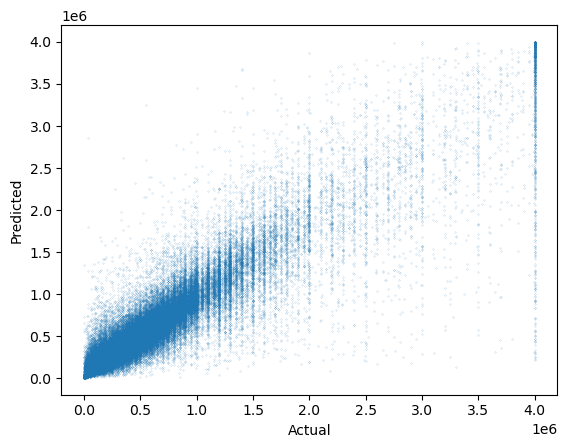

In [13]:
model_rf2, X_rf2, y_val_pred_rf2, resids_rf2, percenterror_rf2 = build_model(RandomForestRegressor(n_estimators = 200, min_samples_leaf=2))

In [ ]:
joblib.dump(model_rf2, "C:/Users/44756/Documents/Postgrad/DSA8030/model_rf.joblib")

['C:/Users/44756/Documents/Postgrad/DSA8030/model_rf.joblib']

In [17]:
new_model = joblib.load("C:/Users/44756/Documents/Postgrad/DSA8030/model_rf.joblib")

In [18]:
new_model.feature_importances_

array([8.68543001e-03, 2.09914074e-01, 3.27337542e-02, 1.27144792e-01,
       3.25517720e-02, 1.98003821e-01, 1.43454604e-02, 4.56069361e-04,
       1.83097011e-02, 8.43937005e-03, 9.49144875e-03, 7.46996559e-03,
       5.39606515e-03, 5.18859499e-04, 2.70581057e-02, 3.23150796e-02,
       8.94528540e-03, 1.90179112e-02, 1.00024563e-02, 5.92064778e-02,
       9.16479978e-03, 6.57128351e-02, 5.37033671e-02, 3.00029559e-02,
       2.57957546e-05, 3.35878571e-05, 1.71791180e-04, 4.07702501e-03,
       3.35549367e-04, 2.70433671e-07, 2.24696348e-05, 8.40577662e-04,
       4.92851871e-04, 8.29982931e-05, 1.74386776e-05, 1.07040859e-04,
       3.30163849e-04, 3.14319141e-06, 1.08459813e-04, 2.82223495e-05,
       3.50413981e-05, 7.40522848e-06, 5.92020215e-08, 2.63827878e-04,
       7.58977086e-05, 1.51711088e-05, 2.01219345e-05, 8.22782780e-06,
       6.05903287e-05, 9.49892939e-05, 4.70297541e-05, 6.25098052e-05,
       8.27883699e-09, 1.30456078e-04, 3.01531764e-05, 3.69453340e-04,
      

R^2 0.8364133377534431
RMSE 199717.6215321864
MAE 93224.9425260698
Positive residuals: 72257
Negative residuals: 88732
Average positive residual: 100202.52135779797
Average negative residual: -87579.67316827588
Average percentage error: 36.78860645848825


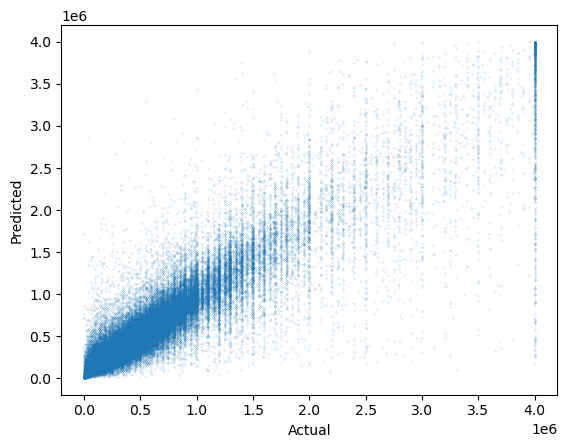

In [12]:
model_rf3, X_rf3, y_val_pred_rf3, resids_rf3, percenterror_rf3 = build_model(RandomForestRegressor(min_samples_split=3))

R^2 0.8392531551131155
RMSE 197976.51195506396
MAE 92612.8384689827
Positive residuals: 72382
Negative residuals: 88631
Average positive residual: 100702.5757509203
Average negative residual: -86017.71235376291
Average percentage error: 33.162918287905946


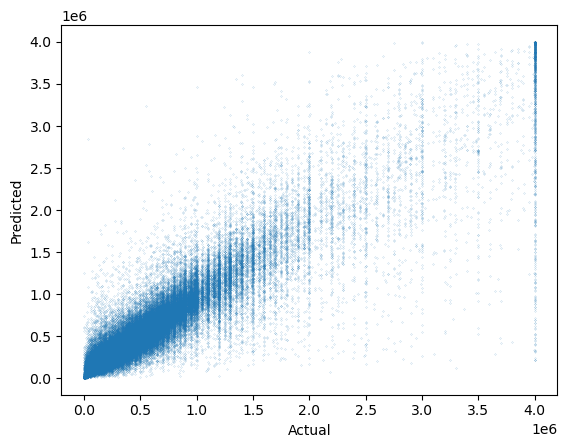

In [54]:
model_rf4, X_rf4, y_val_pred_rf4, resids_rf4, percenterror_rf4 = build_model(RandomForestRegressor(min_samples_leaf=2))

In [ ]:
R^2 0.8394836385134672
RMSE 197834.52886376428
MAE 92635.37233903912
Positive residuals: 72478
Negative residuals: 88532
Average positive residual: 100544.316531588
Average negative residual: -86175.24987512993
Average percentage error: 34.00896189141642

LightGBM (all variables, default hyperparameters)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5114
[LightGBM] [Info] Number of data points in the train set: 483072, number of used features: 71
[LightGBM] [Info] Start training from score 470337.680414
R^2 0.8128434839192689
RMSE 213621.47811762794
MAE 111616.20046861436
Positive residuals: 72401
Negative residuals: 88623
Average positive residual: 124406.86778577826
Average negative residual: -101166.80127844946
Average percentage error: 23.105084798720576


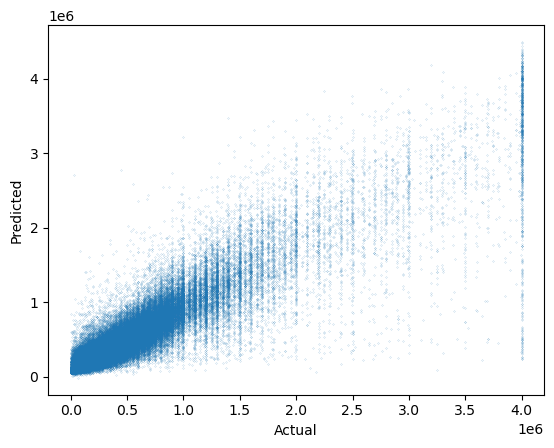

In [26]:
model_lgbm1, X_lgbm1, y_val_pred_lgbm1, resids_lgbm1, percenterror_lgbm1 = build_model(lgb.LGBMRegressor())

In [29]:
pd.DataFrame([model_lgbm1.feature_name_, model_lgbm1.feature_importances_]).T.sort_values(by = 1, ascending = False)

0    1
3    house_size  407
5       longzip  276
2      acre_lot  237
21  totalincome  200
14   population  191
..          ...  ...
45     Michigan    0
46    Minnesota    0
47  Mississippi    0
50     Nebraska    0
73      Wyoming    0

[74 rows x 2 columns]

In [ ]:
params = [{'n_estimators': [500,600,700,800],
         'learning_rate': [0.01,0.05,0.1]}]

gs_lgbm = GridSearchCV(lgb.LGBMRegressor(),
                      param_grid=params,
                      scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'],
                      refit='r2',
                      cv=5,
                      verbose=3)

X = sold[['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']]
y = sold['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

gs_lgbm.fit(X_train, y_train)
gs_lgbm.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5114
[LightGBM] [Info] Number of data points in the train set: 483072, number of used features: 72
[LightGBM] [Info] Start training from score 470169.473031
[CV 1/5] END learning_rate=0.01, n_estimators=500; neg_mean_absolute_error: (test=-120655.178) neg_root_mean_squared_error: (test=-222716.336) r2: (test=0.795) total time=  21.1s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5113
[LightGBM] [Info] Number of data points in the train set

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.095950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5114
[LightGBM] [Info] Number of data points in the train set: 483072, number of used features: 71
[LightGBM] [Info] Start training from score 470337.680414
R^2 0.8353194851967929
RMSE 200384.2334911614
MAE 102646.77721524707
Positive residuals: 72782
Negative residuals: 88242
Average positive residual: 113868.45491602976
Average negative residual: -93391.13765111243
Average percentage error: 23.07902267169189


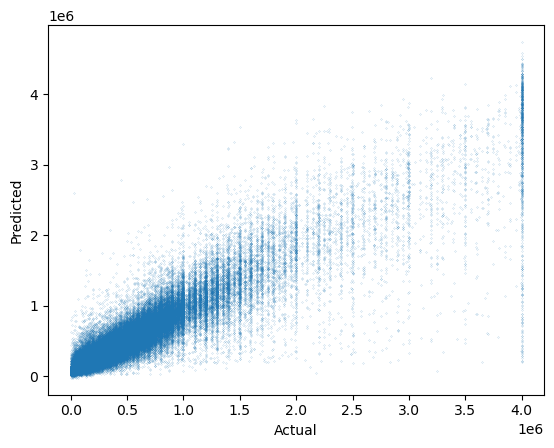

In [65]:
model_lgbm2, X_lgbm2, y_val_pred_lgbm2, resids_lgbm2, percenterror_lgbm2 = build_model(lgb.LGBMRegressor(n_estimators=300, learning_rate = 0.1))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5114
[LightGBM] [Info] Number of data points in the train set: 483072, number of used features: 71
[LightGBM] [Info] Start training from score 470337.680414
R^2 0.8423847351753991
RMSE 196038.59337290877
MAE 99631.52933563448
Positive residuals: 73354
Negative residuals: 87670
Average positive residual: 109710.34117110845
Average negative residual: -91198.52872676763
Average percentage error: 23.594871432507134


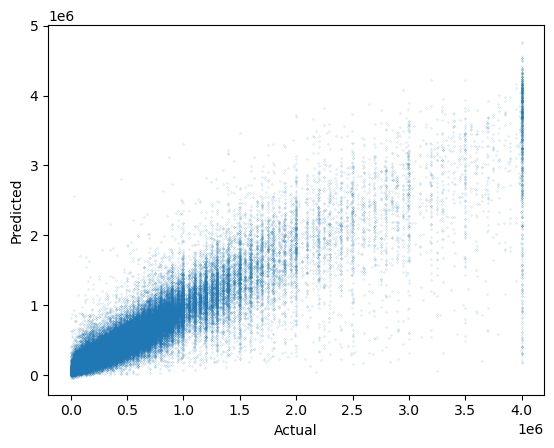

In [31]:
model_lgbm3, X_lgbm3, y_val_pred_lgbm3, resids_lgbm3, percenterror_lgbm3 = build_model(lgb.LGBMRegressor(n_estimators=500, learning_rate = 0.1))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 483072, number of used features: 59
[LightGBM] [Info] Start training from score 470337.680414
R^2 0.8424907091568019
RMSE 195972.67817266838
MAE 99629.91833392004
Positive residuals: 73305
Negative residuals: 87719
Average positive residual: 109641.00468166043
Average negative residual: -91263.85528348503
Average percentage error: 23.899598473557738


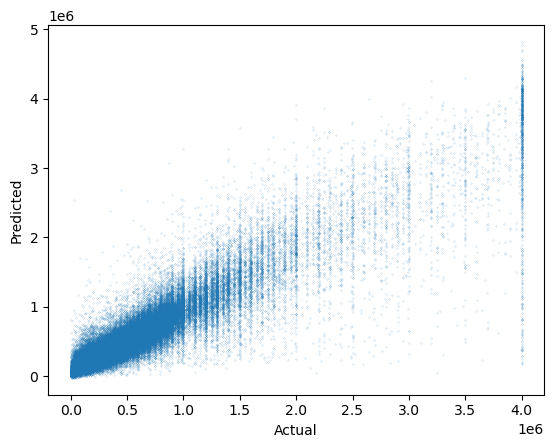

In [40]:
model_lgbm4, X_lgbm4, y_val_pred_lgbm4, resids_lgbm4, percenterror_lgbm4 = build_model(lgb.LGBMRegressor(n_estimators=500, learning_rate = 0.1), cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Iowa', 'Kansas', 'Kentucky', 'Maryland', 'Mississippi', 'Missouri', 'Montana', 'Nevada', 'New Jersey', 'New York', 'North Carolina', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'Tennessee', 'Texas', 'Utah', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 483072, number of used features: 59
[LightGBM] [Info] Start training from score 470337.680414
R^2 0.8424110050606266
RMSE 196022.25572326285
MAE 99641.09788198948
Positive residuals: 73370
Negative residuals: 87654
Average positive residual: 109625.56552805618
Average negative residual: -91283.68816660957
Average percentage error: 24.085786801450112


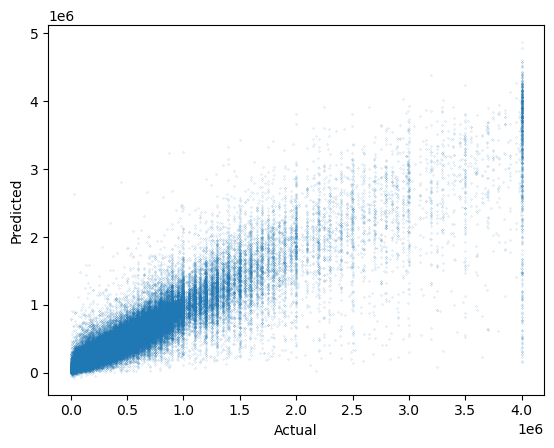

In [29]:
model_lgbm5, X_lgbm5, y_val_pred_lgbm5, resids_lgbm5, percenterror_lgbm5 = build_model(lgb.LGBMRegressor(n_estimators=500, learning_rate = 0.1), cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'California', 'Colorado', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Kansas', 'Kentucky', 'Maryland', 'Mississippi', 'Missouri', 'Montana', 'Nevada', 'New Jersey', 'New York', 'North Carolina', 'Ohio', 'Oklahoma', 'Rhode Island', 'South Carolina', 'Texas', 'Utah', 'Virginia', 'West Virginia', 'Wisconsin', 'Tennessee', 'Pennsylvania', 'Iowa', 'Arizona', 'Oregon', 'Arkansas', 'Connecticut', 'otherstate_lgbm'])

In [38]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pd.DataFrame([model_lgbm3.feature_name_, model_lgbm3.feature_importances_]).T.sort_values(by = [1,0], ascending = False))
pd.reset_option('display.max_columns')

0     1
3             house_size  1842
2               acre_lot  1317
5                longzip   927
19                dshore   867
21           totalincome   823
15               density   744
1                   bath   718
4                 latzip   684
14            population   643
6               cityfreq   626
17             dlairport   565
8             brokerfreq   550
23           tax_returns   520
20            nobusiness   519
0                    bed   509
18             dmairport   500
9          precipitation   469
16              dhighway   464
11               mintemp   339
10               maxtemp   313
22        adjustedincome   252
12               avgtemp   165
27            California    55
66                 Texas    47
13                po_box    37
55              New_York    30
67                  Utah    24
32               Florida    24
72             Wisconsin    23
48              Missouri    22
36              Illinois    22
31  District_of_Columbia    22
7             streetfreq    21
59              Oklahoma    21
43              Maryland    21
69              Virginia    20
58                  Ohio    20
56        North_Carolina    20
49               Montana    19
53            New_Jersey    15
62          Rhode_Island    13
51                Nevada    13
40              Kentucky    13
39                Kansas    13
35                 Idaho    13
33               Georgia    11
71         West_Virginia    10
34                Hawaii    10
28              Colorado    10
63        South_Carolina     9
47           Mississippi     9
65             Tennessee     7
61          Pennsylvania     7
38                  Iowa     7
25               Arizona     7
60                Oregon     6
26              Arkansas     6
29           Connecticut     4
70            Washington     3
54            New_Mexico     2
50              Nebraska     2
44         Massachusetts     2
30              Delaware     2
24               Alabama     2
73               Wyoming     0
68               Vermont     0
64          South_Dakota     0
57          North_Dakota     0
52         New_Hampshire     0
46             Minnesota     0
45              Michigan     0
42                 Maine     0
41             Louisiana     0
37               Indiana     0

CatBoost (all variables, default hyperparameters)

Learning rate set to 0.108706
0:	learn: 464993.8893613	total: 171ms	remaining: 2m 51s
1:	learn: 441246.1419357	total: 220ms	remaining: 1m 49s
2:	learn: 420064.8396678	total: 261ms	remaining: 1m 26s
3:	learn: 401362.8975264	total: 301ms	remaining: 1m 14s
4:	learn: 385558.5835477	total: 341ms	remaining: 1m 7s
5:	learn: 371531.4728224	total: 380ms	remaining: 1m 2s
6:	learn: 358965.6358594	total: 426ms	remaining: 1m
7:	learn: 347668.8224229	total: 474ms	remaining: 58.8s
8:	learn: 338247.3862256	total: 520ms	remaining: 57.3s
9:	learn: 329939.9173141	total: 567ms	remaining: 56.1s
10:	learn: 322194.2516630	total: 618ms	remaining: 55.6s
11:	learn: 315411.0827715	total: 665ms	remaining: 54.7s
12:	learn: 309384.4646597	total: 713ms	remaining: 54.1s
13:	learn: 304097.7442312	total: 750ms	remaining: 52.8s
14:	learn: 299238.3234536	total: 790ms	remaining: 51.9s
15:	learn: 294751.8592723	total: 833ms	remaining: 51.2s
16:	learn: 291057.8567920	total: 880ms	remaining: 50.9s
17:	learn: 287687.2853973	t

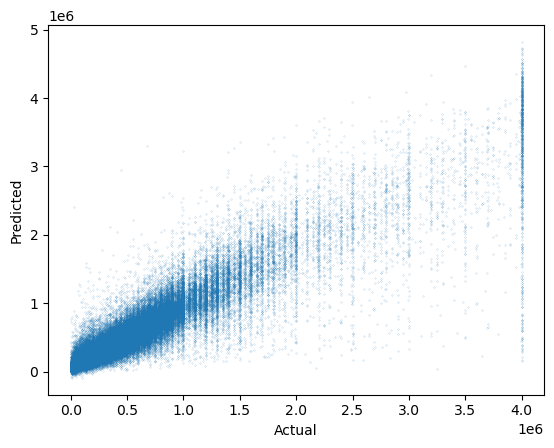

In [30]:
model_cb1, X_cb1, y_val_pred_cb1, resids_cb1, percenterror_cb1 = build_model(CatBoostRegressor(), cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'n'])

In [32]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pd.DataFrame([model_cb1.feature_names_, model_cb1.feature_importances_]).T.sort_values(by = [1,0], ascending = False))
pd.reset_option('display.max_columns')

0          1
3       house_size  17.309625
5          longzip  12.488367
1             bath  10.842225
24               n   9.653242
21     totalincome   8.885822
19          dshore   7.894955
22  adjustedincome   7.502146
14      population   4.099293
15         density    3.64177
2         acre_lot   3.138426
23     tax_returns   3.100357
4           latzip   1.701727
17       dlairport   1.644772
0              bed    1.49505
9    precipitation   1.446349
6         cityfreq   0.957312
11         mintemp   0.922076
10         maxtemp   0.765028
20      nobusiness   0.694492
12         avgtemp   0.690927
16        dhighway   0.363295
18       dmairport    0.35156
8       brokerfreq   0.262729
13          po_box   0.131239
7       streetfreq   0.017219

Learning rate set to 0.078179
0:	learn: 472682.2591968	total: 98.1ms	remaining: 2m 27s
1:	learn: 454703.5678099	total: 167ms	remaining: 2m 5s
2:	learn: 438181.2035705	total: 235ms	remaining: 1m 57s
3:	learn: 423464.0266533	total: 301ms	remaining: 1m 52s
4:	learn: 409716.7483208	total: 365ms	remaining: 1m 49s
5:	learn: 397158.1657696	total: 427ms	remaining: 1m 46s
6:	learn: 385781.5846476	total: 486ms	remaining: 1m 43s
7:	learn: 375491.9773014	total: 549ms	remaining: 1m 42s
8:	learn: 366104.0306410	total: 609ms	remaining: 1m 40s
9:	learn: 357657.4959030	total: 670ms	remaining: 1m 39s
10:	learn: 349589.3617205	total: 736ms	remaining: 1m 39s
11:	learn: 342763.8680671	total: 796ms	remaining: 1m 38s
12:	learn: 336101.2541479	total: 870ms	remaining: 1m 39s
13:	learn: 330210.3593781	total: 940ms	remaining: 1m 39s
14:	learn: 324760.1653814	total: 1.01s	remaining: 1m 39s
15:	learn: 319818.5451623	total: 1.08s	remaining: 1m 39s
16:	learn: 315266.4878585	total: 1.15s	remaining: 1m 40s
17:	learn: 

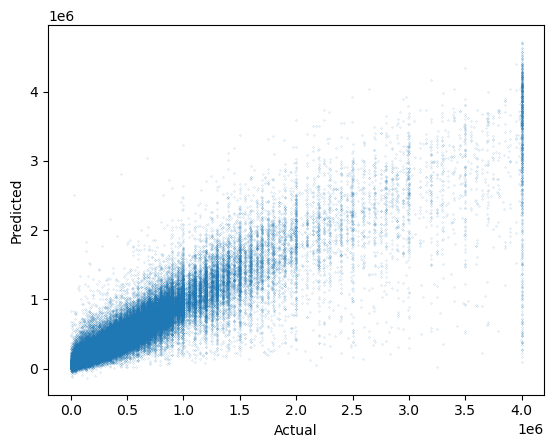

In [14]:
model_cb2, X_cb2, y_val_pred_cb2, resids_cb2, percenterror_cb2 = build_model(CatBoostRegressor(iterations=1500), cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'n'])

Learning rate set to 0.061875
0:	learn: 476841.5500633	total: 251ms	remaining: 8m 21s
1:	learn: 462230.5478259	total: 334ms	remaining: 5m 33s
2:	learn: 448807.6205934	total: 406ms	remaining: 4m 30s
3:	learn: 436103.5221963	total: 471ms	remaining: 3m 54s
4:	learn: 424492.8735346	total: 556ms	remaining: 3m 41s
5:	learn: 413718.0042266	total: 618ms	remaining: 3m 25s
6:	learn: 403684.9798110	total: 681ms	remaining: 3m 13s
7:	learn: 394441.9819481	total: 748ms	remaining: 3m 6s
8:	learn: 385465.2426880	total: 826ms	remaining: 3m 2s
9:	learn: 377148.9194491	total: 898ms	remaining: 2m 58s
10:	learn: 369597.3130973	total: 971ms	remaining: 2m 55s
11:	learn: 362722.5286249	total: 1.07s	remaining: 2m 57s
12:	learn: 356121.7681235	total: 1.14s	remaining: 2m 54s
13:	learn: 350066.8477047	total: 1.21s	remaining: 2m 51s
14:	learn: 344391.9944184	total: 1.28s	remaining: 2m 49s
15:	learn: 339277.7339139	total: 1.35s	remaining: 2m 47s
16:	learn: 334429.9599930	total: 1.42s	remaining: 2m 45s
17:	learn: 32

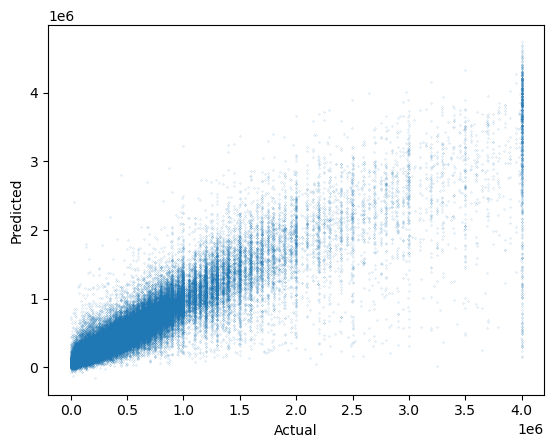

In [15]:
model_cb3, X_cb3, y_val_pred_cb3, resids_cb3, percenterror_cb3 = build_model(CatBoostRegressor(iterations=2000), cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'n'])

Learning rate set to 0.061875
0:	learn: 477060.5774570	total: 65.3ms	remaining: 2m 10s
1:	learn: 462631.1984386	total: 120ms	remaining: 1m 59s
2:	learn: 449011.6369724	total: 178ms	remaining: 1m 58s
3:	learn: 436896.0564732	total: 235ms	remaining: 1m 57s
4:	learn: 425269.3133267	total: 287ms	remaining: 1m 54s
5:	learn: 414377.2586925	total: 340ms	remaining: 1m 53s
6:	learn: 404377.7250740	total: 392ms	remaining: 1m 51s
7:	learn: 394849.5360921	total: 447ms	remaining: 1m 51s
8:	learn: 386219.3966291	total: 502ms	remaining: 1m 50s
9:	learn: 378069.8255519	total: 560ms	remaining: 1m 51s
10:	learn: 370304.6664919	total: 618ms	remaining: 1m 51s
11:	learn: 362998.9213871	total: 675ms	remaining: 1m 51s
12:	learn: 356427.1762575	total: 729ms	remaining: 1m 51s
13:	learn: 350443.6745249	total: 787ms	remaining: 1m 51s
14:	learn: 344762.8593328	total: 843ms	remaining: 1m 51s
15:	learn: 339445.0725087	total: 896ms	remaining: 1m 51s
16:	learn: 334334.0698607	total: 951ms	remaining: 1m 50s
17:	learn:

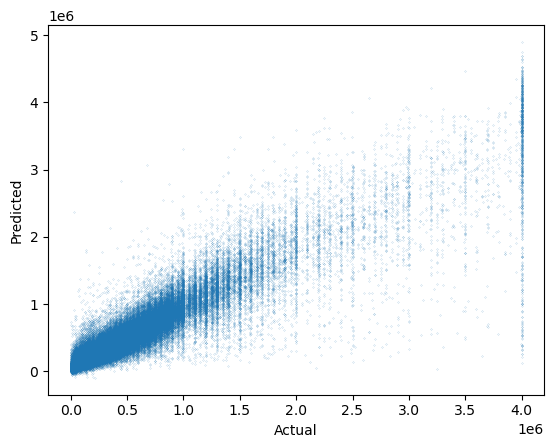

In [26]:
model_cb4, X_cb4, y_val_pred_cb4, resids_cb4, percenterror_cb4 = build_model(CatBoostRegressor(iterations=2000), cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'n'])

Learning rate set to 0.061875
0:	learn: 477153.3158302	total: 43.6ms	remaining: 1m 27s
1:	learn: 462260.9024957	total: 80.4ms	remaining: 1m 20s
2:	learn: 448767.8587445	total: 117ms	remaining: 1m 17s
3:	learn: 436377.4396632	total: 157ms	remaining: 1m 18s
4:	learn: 424409.2821693	total: 201ms	remaining: 1m 20s
5:	learn: 413490.9075145	total: 239ms	remaining: 1m 19s
6:	learn: 403435.6238592	total: 278ms	remaining: 1m 19s
7:	learn: 393954.8884327	total: 313ms	remaining: 1m 17s
8:	learn: 385333.6367294	total: 347ms	remaining: 1m 16s
9:	learn: 377137.3133944	total: 381ms	remaining: 1m 15s
10:	learn: 369504.4239447	total: 418ms	remaining: 1m 15s
11:	learn: 362400.1589436	total: 456ms	remaining: 1m 15s
12:	learn: 355876.5737875	total: 494ms	remaining: 1m 15s
13:	learn: 349742.9288363	total: 531ms	remaining: 1m 15s
14:	learn: 344117.9120223	total: 568ms	remaining: 1m 15s
15:	learn: 338771.2848664	total: 608ms	remaining: 1m 15s
16:	learn: 333861.0805701	total: 644ms	remaining: 1m 15s
17:	learn

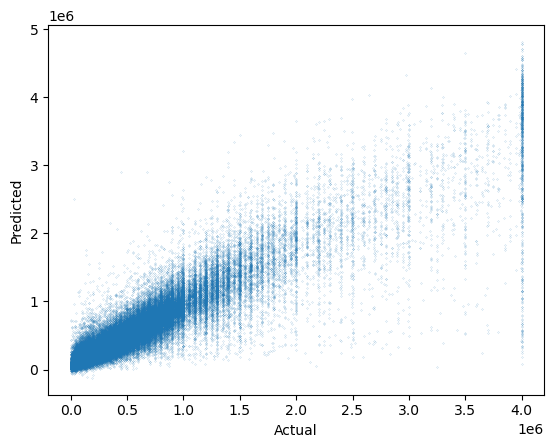

In [30]:
model_cb5, X_cb5, y_val_pred_cb5, resids_cb5, percenterror_cb5 = build_model(CatBoostRegressor(iterations=2000), cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'population', 'density', 'dlairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'n'])

Learning rate set to 0.061875
0:	learn: 476833.0710194	total: 55.1ms	remaining: 1m 50s
1:	learn: 462096.9794857	total: 96.1ms	remaining: 1m 35s
2:	learn: 448747.5755273	total: 134ms	remaining: 1m 29s
3:	learn: 436222.5927249	total: 172ms	remaining: 1m 26s
4:	learn: 424627.8261063	total: 213ms	remaining: 1m 24s
5:	learn: 413749.0171915	total: 254ms	remaining: 1m 24s
6:	learn: 403498.2518429	total: 300ms	remaining: 1m 25s
7:	learn: 393991.5811054	total: 344ms	remaining: 1m 25s
8:	learn: 385328.6943064	total: 390ms	remaining: 1m 26s
9:	learn: 377131.0043322	total: 436ms	remaining: 1m 26s
10:	learn: 369700.3169720	total: 476ms	remaining: 1m 26s
11:	learn: 362771.3060067	total: 515ms	remaining: 1m 25s
12:	learn: 356381.7498930	total: 555ms	remaining: 1m 24s
13:	learn: 349980.6045303	total: 598ms	remaining: 1m 24s
14:	learn: 344277.8200972	total: 641ms	remaining: 1m 24s
15:	learn: 339297.6590786	total: 686ms	remaining: 1m 25s
16:	learn: 334303.8477186	total: 729ms	remaining: 1m 25s
17:	learn

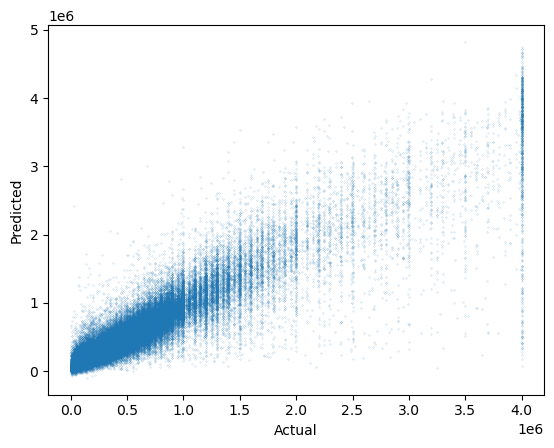

In [28]:
model_cb6, X_cb6, y_val_pred_cb6, resids_cb6, percenterror_cb6 = build_model(CatBoostRegressor(iterations=2000), cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'precipitation', 'mintemp', 'avgtemp', 'population', 'density', 'dlairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'n'])

Learning rate set to 0.061875
0:	learn: 477131.1236634	total: 39.9ms	remaining: 1m 19s
1:	learn: 462637.0369154	total: 76.7ms	remaining: 1m 16s
2:	learn: 448977.8304302	total: 112ms	remaining: 1m 14s
3:	learn: 436633.5336881	total: 146ms	remaining: 1m 12s
4:	learn: 425169.8279447	total: 180ms	remaining: 1m 11s
5:	learn: 414092.5950407	total: 214ms	remaining: 1m 11s
6:	learn: 403938.8143725	total: 250ms	remaining: 1m 11s
7:	learn: 394612.0185254	total: 288ms	remaining: 1m 11s
8:	learn: 385877.6725275	total: 323ms	remaining: 1m 11s
9:	learn: 377782.8357579	total: 357ms	remaining: 1m 11s
10:	learn: 370283.1698014	total: 397ms	remaining: 1m 11s
11:	learn: 362993.7290128	total: 441ms	remaining: 1m 13s
12:	learn: 356527.0392812	total: 487ms	remaining: 1m 14s
13:	learn: 350358.0268464	total: 533ms	remaining: 1m 15s
14:	learn: 344590.2710316	total: 585ms	remaining: 1m 17s
15:	learn: 339219.2228249	total: 629ms	remaining: 1m 17s
16:	learn: 334306.3723188	total: 674ms	remaining: 1m 18s
17:	learn

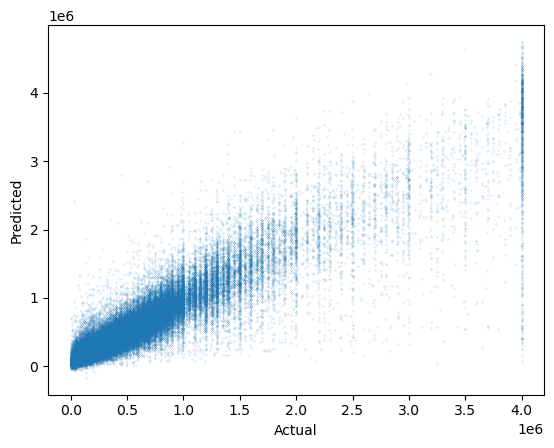

In [29]:
model_cb6, X_cb6, y_val_pred_cb6, resids_cb6, percenterror_cb6 = build_model(CatBoostRegressor(iterations=2000), cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'precipitation', 'mintemp', 'population', 'density', 'dlairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'n'])

In [ ]:
pd.DataFrame([model_cb3.feature_importances_, ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'n']]).T.sort_values(by = 0, ascending = False)

0               1
3   16.905623      house_size
5   13.862632         longzip
1   10.618256            bath
22   8.911051  adjustedincome
24   8.041708               n
19   7.845273          dshore
21   7.682917     totalincome
14   4.351407      population
15   3.623354         density
2    3.201055        acre_lot
23   2.929665     tax_returns
4    1.823849          latzip
9    1.742725   precipitation
0    1.477203             bed
17   1.433787       dlairport
11   1.240587         mintemp
6    1.086934        cityfreq
20   0.766618      nobusiness
12   0.637553         avgtemp
10   0.621344         maxtemp
16   0.374296        dhighway
18   0.355348       dmairport
8    0.311452      brokerfreq
13   0.138787          po_box
7    0.016578      streetfreq

In [22]:
params = [{'iterations': [100,200,300],
         'learning_rate': [0.01,0.05,0.1]}]

gs_cb = GridSearchCV(CatBoostRegressor(),
                      param_grid=params,
                      scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'],
                      refit='r2',
                      cv=5,
                      verbose=3)

X = sold[['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'n']]
y = sold['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

gs_cb.fit(X_train, y_train)
gs_cb.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0:	learn: 490821.1292455	total: 159ms	remaining: 15.8s
1:	learn: 488267.3926235	total: 245ms	remaining: 12s
2:	learn: 485733.2460098	total: 317ms	remaining: 10.3s
3:	learn: 483217.4879850	total: 408ms	remaining: 9.8s
4:	learn: 480754.5780362	total: 519ms	remaining: 9.87s
5:	learn: 478334.0699008	total: 616ms	remaining: 9.65s
6:	learn: 475954.4397059	total: 708ms	remaining: 9.41s
7:	learn: 473544.0484026	total: 792ms	remaining: 9.11s
8:	learn: 471176.7639577	total: 884ms	remaining: 8.94s
9:	learn: 468912.9538011	total: 970ms	remaining: 8.73s
10:	learn: 466621.3931224	total: 1.05s	remaining: 8.49s
11:	learn: 464363.5776669	total: 1.12s	remaining: 8.25s
12:	learn: 462119.4945959	total: 1.2s	remaining: 8.01s
13:	learn: 459929.1186859	total: 1.27s	remaining: 7.8s
14:	learn: 457771.3898667	total: 1.34s	remaining: 7.58s
15:	learn: 455614.5926155	total: 1.41s	remaining: 7.42s
16:	learn: 453519.7923517	total: 1.49s	remaining: 7.26s
17:

KeyboardInterrupt: 

SVM (all variables, default hyperparameters)

c:\Users\44756\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


R^2 0.3360241920093787
RMSE 402363.49117137486
MAE 242587.5562279942


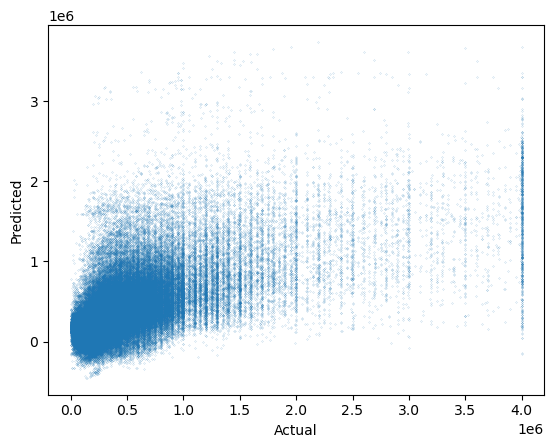

In [ ]:
model_svm1, X_svm1, y_val_pred_svm1, resids_svm1, percenterror_svm1 = build_model(LinearSVR())

Linear Regression (main variables only, log price)

R^2 0.4501950982591425
RMSE 360905.48570894153
MAE 185929.28176297998
Positive residuals: 91856
Negative residuals: 69168
Average positive residual: 221442.49610742557
Average negative residual: -138767.27307654414
Average percentage error: 18.286403823898663


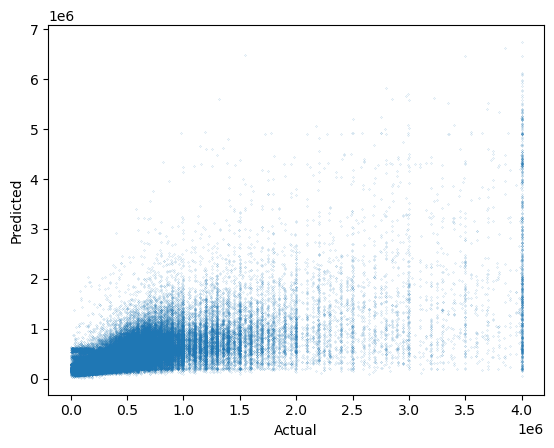

In [28]:
model_lr1_log, X_lr1_log, y_val_pred_lr1_log, resids_lr1_log, percenterror_lr1_log = build_model_log(LinearRegression(), ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

Linear Regression (main + climate variables only, log price)

R^2 0.47583796821602264
RMSE 350509.32700821484
MAE 177925.8625110473
Positive residuals: 92586
Negative residuals: 68438
Average positive residual: 207652.43367348926
Average negative residual: -137710.42200071897
Average percentage error: 18.441661814769706


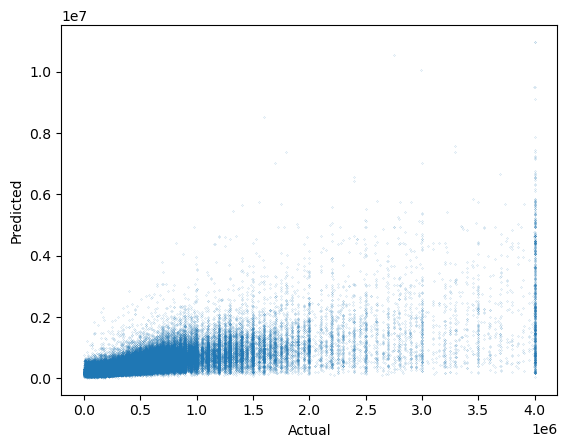

In [29]:
model_lr2_log, X_lr2_log, y_val_pred_lr2_log, resids_lr2_log, percenterror_lr2_log = build_model_log(LinearRegression(), ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

Linear Regression (main + facilities/demo variables, log price)

R^2 0.5532137318722673
RMSE 340271.19311821746
MAE 161224.38773978184
Positive residuals: 93835
Negative residuals: 67189
Average positive residual: 172768.64324584138
Average negative residual: -145101.8793617573
Average percentage error: 16.177883776516257


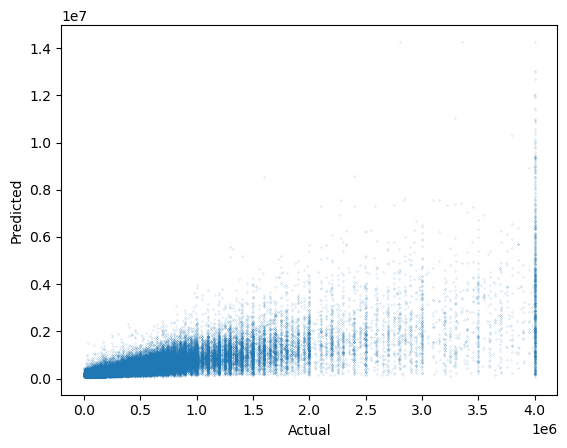

In [30]:
model_lr3_log, X_lr3_log, y_val_pred_lr3_log, resids_lr3_log, percenterror_lr3_log = build_model_log(LinearRegression(),['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

Linear Regression (all vars, log price)

R^2 0.5552311866620578
RMSE 343552.568302323
MAE 160968.68563215638
Positive residuals: 94140
Negative residuals: 66884
Average positive residual: 171122.05524142258
Average negative residual: -146677.7010167578
Average percentage error: 16.270038730636053


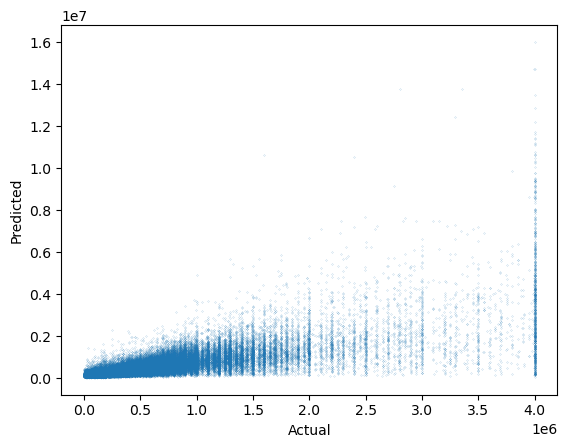

In [31]:
model_lr4_log, X_lr4_log, y_val_pred_lr4_log, resids_lr4_log, percenterror_lr4_log = build_model_log(LinearRegression())

XGBoost (all vars, default hyper, log price)

R^2 0.7950090519640406
RMSE 218115.32375232005
MAE 103633.82595172903
Positive residuals: 84711
Negative residuals: 76313
Average positive residual: 120249.45813154944
Average negative residual: -85189.69693590255
Average percentage error: 16.1595902635365


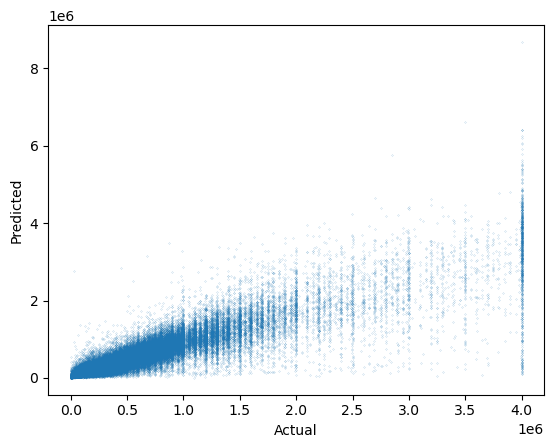

In [32]:
model_lr4_log, X_lr4_log, y_val_pred_lr4_log, resids_lr4_log, percenterror_lr4_log = build_model_log(xgb.XGBRegressor(eval_metric=['mae', 'rmse']))

Decision Tree Regressor (all vars, default hyper, log price)

R^2 0.6548311706871328
RMSE 274539.3252382711
MAE 126452.31858386722
Positive residuals: 78739
Negative residuals: 78785
Average positive residual: 128291.27135238599
Average negative residual: -130232.04585432645
Average percentage error: 31.9042833349289


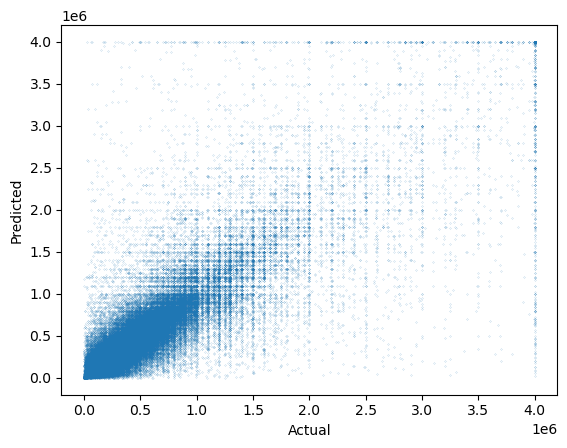

In [33]:
model_dt1_log, X_dt1_log, y_val_pred_dt1_log, resids_dt1_log, percenterror_dt1_log = build_model_log(DecisionTreeRegressor())

Random Forest Regressor (all vars, default hyper, log price)

R^2 0.8203888819897406
RMSE 201108.57708228016
MAE 90169.45480852874
Positive residuals: 85093
Negative residuals: 75929
Average positive residual: 107019.85577475031
Average negative residual: -71287.72542306241
Average percentage error: 18.651841257886545


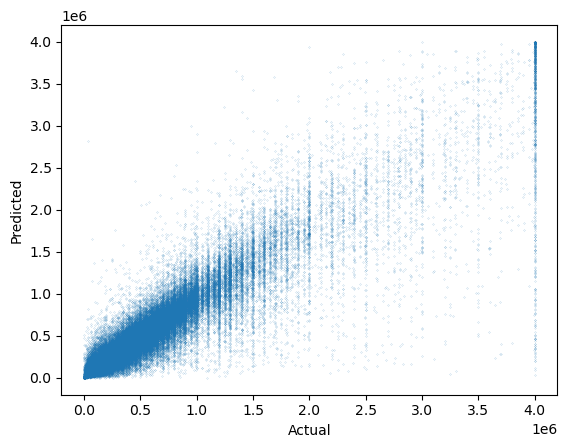

In [34]:
model_rf1_log, X_rf1_log, y_val_pred_rf1_log, resids_rf1_log, percenterror_rf1_log = build_model_log(RandomForestRegressor())

SVG (all variables, default hyper, log price)

c:\Users\44756\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


R^2 -12.009300425404959
RMSE 7165799046160.989
MAE 214290606160.12494


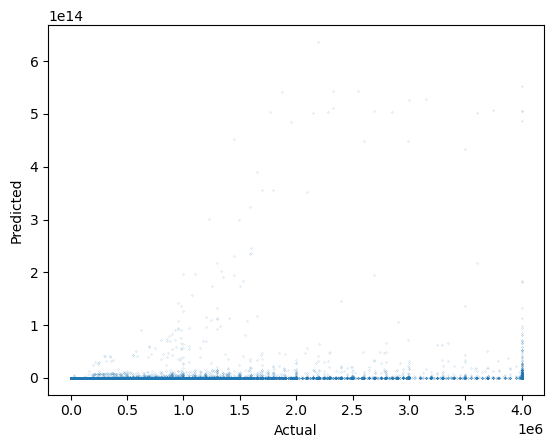

In [ ]:
model_svm1_log, X_svm1_log, y_val_pred_svm1_log, resids_svm1_log, percenterror_svm1_log = build_model_log(LinearSVR())

Analysis

In [14]:
model_rf = joblib.load("C:/Users/44756/Documents/Postgrad/DSA8030/model_rf.joblib")
model_xgb = joblib.load("C:/Users/44756/Documents/Postgrad/DSA8030/model_xgb.joblib")

R^2 0.849282895673609
RMSE 190172.85930588175
MAE 93090.49437727616
Positive residuals: 72215
Negative residuals: 88800
Average positive residual: 99551.9918372913
Average negative residual: -86177.89940664369
Average percentage error: 57.418330934896915


Text(0, 0.5, 'Predicted')

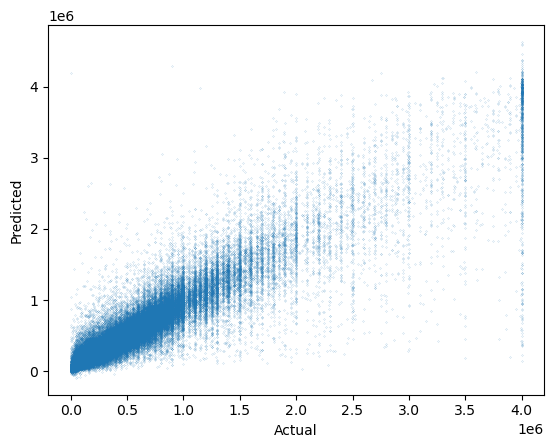

In [19]:
xgb_x = sold_test[['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns','Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maryland', 'Massachusetts', 'Michigan', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Jersey', 'New York', 'North Carolina', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'otherstate_xgb']]
xgb_y = sold_test['price']
xgb_pred = model_xgb.predict(xgb_x)

resids_xgb = xgb_y - xgb_pred
percenterror_xgb = (xgb_y - xgb_pred) / xgb_y
print('R^2', model_xgb.score(xgb_x, xgb_y))
print('RMSE', root_mean_squared_error(xgb_y, xgb_pred))
print('MAE', mean_absolute_error(xgb_y, xgb_pred))
print('Positive residuals:', len(resids[resids > 0]))
print('Negative residuals:', len(resids[resids < 0]))
print('Average positive residual:', np.mean(resids[resids > 0]))
print('Average negative residual:', np.mean(resids[resids < 0]))
print('Average percentage error:', np.mean(abs(percenterror)))
plt.scatter(xgb_y, xgb_pred, s = 0.01)
plt.xlabel('Actual')
plt.ylabel('Predicted')

R^2 0.8410817670992683
RMSE 195278.3645046487
MAE 92171.00902871591
Positive residuals: 72215
Negative residuals: 88800
Average positive residual: 99551.9918372913
Average negative residual: -86177.89940664369
Average percentage error: 57.418330934896915


Text(0, 0.5, 'Predicted')

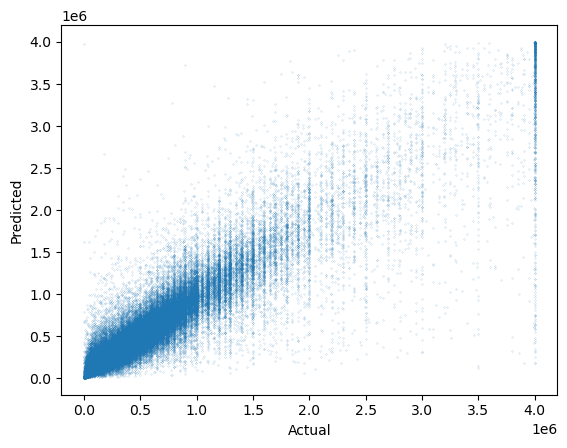

In [20]:
rf_x = sold_test[['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']]
rf_y = sold_test['price']
rf_pred = model_rf.predict(rf_x)

resids_rf = rf_y - rf_pred
percenterror_rf = (rf_y - rf_pred) / rf_y
print('R^2', model_rf.score(rf_x, rf_y))
print('RMSE', root_mean_squared_error(rf_y, rf_pred))
print('MAE', mean_absolute_error(rf_y, rf_pred))
print('Positive residuals:', len(resids[resids > 0]))
print('Negative residuals:', len(resids[resids < 0]))
print('Average positive residual:', np.mean(resids[resids > 0]))
print('Average negative residual:', np.mean(resids[resids < 0]))
print('Average percentage error:', np.mean(abs(percenterror)))
plt.scatter(rf_y, rf_pred, s = 0.01)
plt.xlabel('Actual')
plt.ylabel('Predicted')

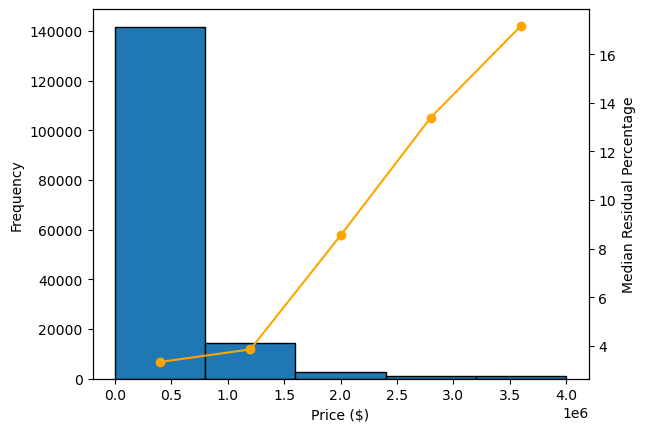

In [32]:
# RF %age error univariate
fig, ax = plt.subplots()

hist = ax.hist(sold_test.price, ec = 'black', bins = 5)
midpts = [((hist[1][x] + hist[1][x+1])/2) for x in range(len(hist[1])-1)]
prices = [np.abs(percenterror_rf[(sold_test.price >= hist[1][x]) & (sold_test.price < hist[1][x+1])].median() * 100) for x in range(len(hist[1])-1)]
ax.set_xlabel('Price ($)')
ax.set_ylabel('Frequency')
ax2 = ax.twinx()
ax2.plot(midpts, prices, color = 'orange')
ax2.scatter(midpts, prices, color = 'orange')
ax2.set_ylabel('Median Residual Percentage')
plt.show()

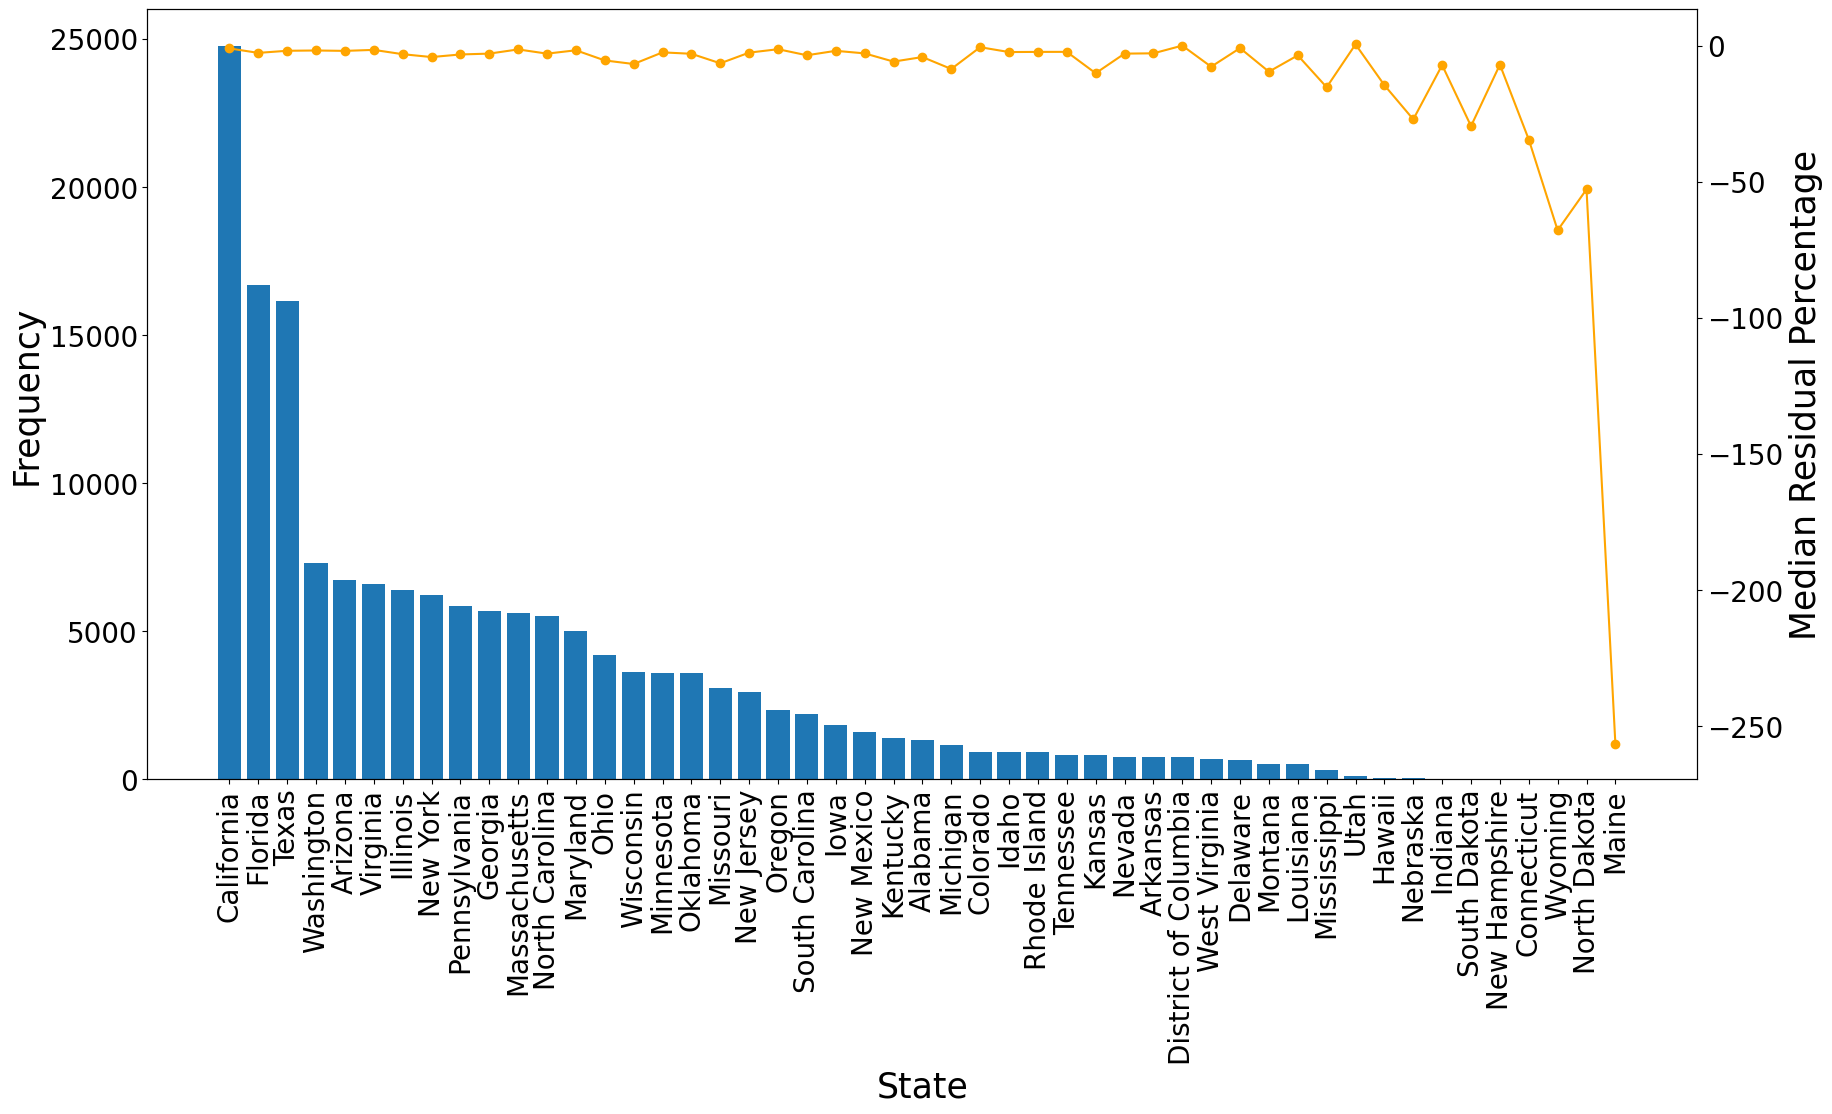

In [ ]:
# RF states %age error
fig, ax = plt.subplots(figsize=(20,10))

states = sold_test.groupby('state').describe()['price'].sort_values(by = 'count', ascending = False).index.tolist()
freq = [len(sold_test[sold_test['state'] == st]) for st in states]
prices = [percenterror_rf[sold_test.state == st].median() * 100 for st in states]

ax.bar(states, freq)
ax.tick_params(axis='both', labelsize = '20')
ax.set_xlabel('State', fontsize = 25)
ax.set_ylabel('Frequency', fontsize = 25)
plt.xticks(rotation = 90)
ax2 = ax.twinx()
ax2.tick_params(axis='both', labelsize = '20')
ax2.plot(states, prices, color = 'orange')
ax2.scatter(states, prices, color = 'orange')
ax2.set_ylabel('Median Residual Percentage', fontsize = 25)
# ax2.set_yticks(ticks = [200000,400000,600000,800000,1000000], labels = [0.2,0.4,0.6,0.8,1.0])
# plt.tight_layout()
# plt.savefig('C:/Users/44756/Documents/Postgrad/DSA8030/states.pdf')
plt.show()

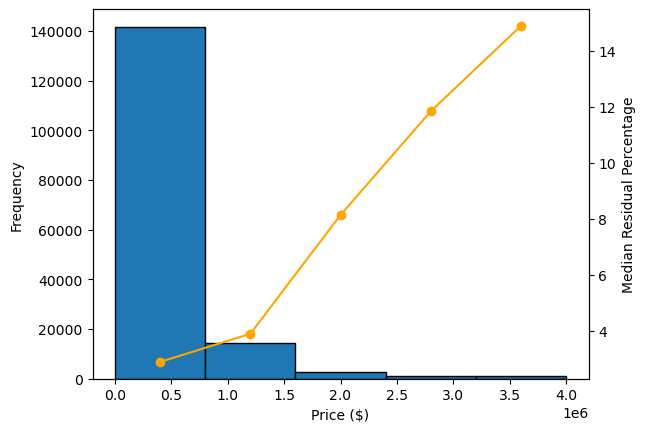

In [31]:
# XGB %age error univariate
fig, ax = plt.subplots()

hist = ax.hist(sold_test.price, ec = 'black', bins = 5)
midpts = [((hist[1][x] + hist[1][x+1])/2) for x in range(len(hist[1])-1)]
prices = [np.abs(percenterror_xgb[(sold_test.price >= hist[1][x]) & (sold_test.price < hist[1][x+1])].median() * 100) for x in range(len(hist[1])-1)]
ax.set_xlabel('Price ($)')
ax.set_ylabel('Frequency')
ax2 = ax.twinx()
ax2.plot(midpts, prices, color = 'orange')
ax2.scatter(midpts, prices, color = 'orange')
ax2.set_ylabel('Median Residual Percentage')
plt.show()

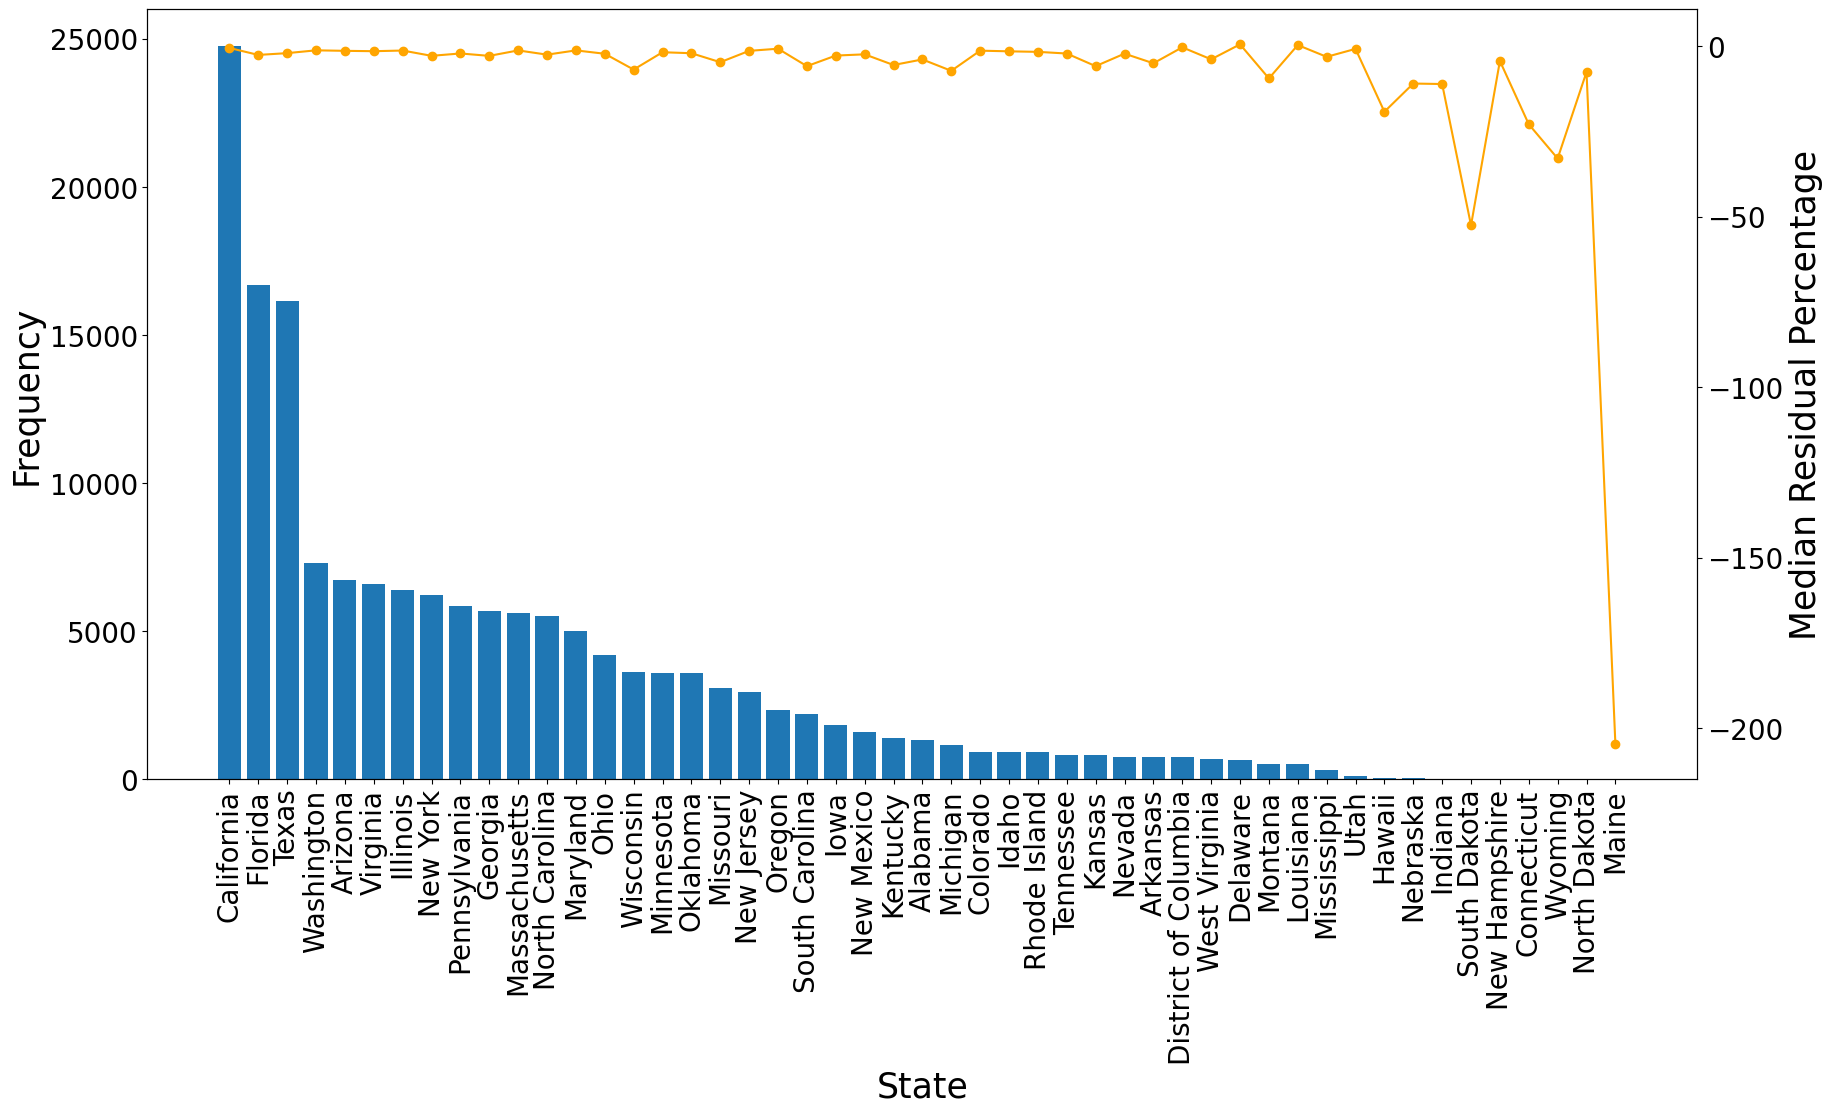

In [30]:
# XGB states %age error
fig, ax = plt.subplots(figsize=(20,10))

states = sold_test.groupby('state').describe()['price'].sort_values(by = 'count', ascending = False).index.tolist()
freq = [len(sold_test[sold_test['state'] == st]) for st in states]
prices = [percenterror_xgb[sold_test.state == st].median() * 100 for st in states]

ax.bar(states, freq)
ax.tick_params(axis='both', labelsize = '20')
ax.set_xlabel('State', fontsize = 25)
ax.set_ylabel('Frequency', fontsize = 25)
plt.xticks(rotation = 90)
ax2 = ax.twinx()
ax2.tick_params(axis='both', labelsize = '20')
ax2.plot(states, prices, color = 'orange')
ax2.scatter(states, prices, color = 'orange')
ax2.set_ylabel('Median Residual Percentage', fontsize = 25)
# ax2.set_yticks(ticks = [200000,400000,600000,800000,1000000], labels = [0.2,0.4,0.6,0.8,1.0])
# plt.tight_layout()
# plt.savefig('C:/Users/44756/Documents/Postgrad/DSA8030/states.pdf')
plt.show()